In [145]:
## Bring in needed mods
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as ss, seaborn as sns
import sys
#sys.path.insert(0, '/../../QTL-functions/SCRIPTS/')
import qtlfunctions as QTLfun
import qtlmovie as QTLmovies

def allelic_manu(geno,pheno,x=0,y=1): ## geno and pheno need to be in the same position
    """
    Conducts a Mann-Whitney U test on the phenotype data in PHENO
    by the genotypic states listed in GENO.
    
    Assumes the order of data within GENO and PHENO are paired.
    Defaluts for the biallelic stat in GENO are 0 and 1; set in X and Y.
    
    Returns the -log10 of the calculated p-value
    """
    pheno = np.array(pheno) ## sets the type for the data as an array
    geno = np.array(geno)
    ## Gather phenotypes by genotypes 
    ## Parse the genotype data as True for 0 and then 1 and 
    ## take the asscoiated index within the phenotypic data array
    ## Return p-value
    return -np.log10(ss.mannwhitneyu(pheno[(geno==x)],pheno[(geno==y)])[1])

def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. 
        Return F-statistic.
    """
    coding = np.array(site,float)
    pheno = np.array(pheno,float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    R = (len_yhat/len_y)**2
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F,R

def association_logPval(site, pheno):
    F,R = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP,R

In [146]:
%matplotlib inline

In [147]:
## Set the random seed
np.random.seed(71191)

## Define parental labels
parents = ['Bt22','Ftc555-1']

In [148]:
## Set paths to phenotype data
## 1) the parental data (parents)
## 2) the initial set of segregants (old)
## 3) the latest set of segregants (new)
## Note, these data where previously processed
## And the halo per replicates / experimetns where calcualted
parent_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_new_parents.csv"
Old_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_old.csv"
New_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_new.csv"

## set path to genotype data and chromosome map
chrommap_path = '../../GENOTYPE/H99_chrommap.csv'

In [149]:
## Bring in genotype data gather the segregants
## and show the frist five rows
loci_path = "../../GENOTYPE/Bt22xFtc555-1_loci_cor.csv.gz"
geno = pd.read_csv(loci_path, index_col = 0)
geno_segs = [s for s in geno.columns if s[:3] == "PMY"]
geno.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2931,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940
Oldindex,,,,,,,,,,,,,,,,,,,,,
5,1,25980,C.T,snp,25980,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
7,1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
12,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
15,1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
17,1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0


In [150]:
## Print the shape
geno.shape

(46760, 330)

In [151]:
## How many segregants are in the genotype data?
len(geno_segs)

322

In [152]:
## Load in chrommap, check length, show head
chrommap = pd.read_csv(chrommap_path)
chrommap.shape[0] >= geno.Chrom.unique().shape[0]
chrommap.head()

,Chrom,Seqid,Length,Cumpos,Midpts
0,1,CP003820.1,2291499,0,1145749.5
1,2,CP003821.1,1621675,2291499,3102336.5
2,3,CP003822.1,1575141,3913174,4700744.5
3,4,CP003823.1,1084805,5488315,6030717.5
4,5,CP003824.1,1814975,6573120,7480607.5


In [153]:
## Bring in GFF file
gffpath = '../../GENOTYPE/FungiDB-46_CneoformansH99.gff'
names = ["Seqid", "Source", "Type", "Start", "End", "Score", 
         "Strand", "Phase", "Attribute"]
dtype = ["str","str","str","int","int","str","str","str","str"]

gff = pd.read_csv(gffpath,comment='#',
                  sep='\t',header=None,
                  names=names,dtype=dict(zip(names,dtype)))

gff['Strand'] = gff['Strand'].replace(dict(zip(['-','+'],[-1,1])))
gff['Parent'] = [a.split('Parent=')[-1].split(';')[0].split('ID=')[-1] 
                 for a in gff.Attribute ]

gff['Gene'] = [a.split('-t26')[0] for a in gff.Parent]

gff = gff.merge(chrommap)

In [154]:
## Gather parental data
## and average by replicate per experiment
PNd = pd.read_csv(parent_data_path)
PNda = PNd.groupby(["PMY","Z"]).mean().reset_index().groupby("PMY").mean().reset_index()
PNda.drop("Z", axis = 1, inplace = True)

## Gather PMY numbers of paretns
Parent_PMY = PNda.PMY.tolist()

## view head
PNda.head()

,PMY,Replicate,Halo
0,PMY2649,2.041667,4.777181
1,PMY2650,2.000000,1.036667


In [155]:
PNd

,PMY,Replicate,Halo,Z
0,PMY2649,1,6.904,0
1,PMY2649,2,4.097,0
2,PMY2649,3,7.451,0
3,PMY2649,1,7.280,1
4,PMY2649,2,6.854,1
...,...,...,...,...
66,PMY2650,2,1.870,22
67,PMY2650,3,1.490,22
68,PMY2650,1,1.029,23
69,PMY2650,2,1.257,23


In [156]:
## Gather the latest data and average across repliacates, view head
Nd = pd.read_csv(New_data_path)
Nda = Nd[~(Nd.isin(Parent_PMY))].groupby("PMY").mean().reset_index()
Nda.head()

,PMY,Replicate,Halo
0,PMY2603,2.0,1.194667
1,PMY2604,2.0,2.377667
2,PMY2605,2.0,6.427667
3,PMY2606,2.0,1.315333
4,PMY2607,2.0,2.287000


In [157]:
Nd.head()

,PMY,Replicate,Halo
0,PMY2603,1,1.383
1,PMY2603,2,0.820
2,PMY2603,3,1.381
3,PMY2604,1,2.483
4,PMY2604,2,2.759


In [158]:
## For the inital (old) data load in and average replicates
Od = pd.read_csv(Old_data_path)
Oda = Od[~(Od.isin(Parent_PMY))].groupby("PMY").mean().reset_index()
Oda.head()

,PMY,Replicate,Halo
0,PMY2556,1.5,3.3180
1,PMY2557,1.5,2.5775
2,PMY2558,1.5,1.0930
3,PMY2559,1.5,0.6710
4,PMY2560,1.5,0.6040


In [159]:
Od.head()

,PMY,Replicate,Halo
0,PMY2556,1,2.613
1,PMY2556,2,4.023
2,PMY2557,1,2.666
3,PMY2557,2,2.489
4,PMY2558,1,0.927


In [160]:
## Concatonate resluts
Halo = pd.concat([PNda, Oda, Nda]).reset_index(drop = True)

## Convert inches to cm
Halo["Halo_in"] = Halo.Halo
cm_con = 2.54
Halo["Halo"] = (np.sqrt(Halo.Halo_in.values)*cm_con)**2

## Set index
Halo.index = Halo.PMY
## View head
Halo.head()

,PMY,Replicate,Halo,Halo_in
PMY,,,,
PMY2649,PMY2649,2.041667,30.820458,4.777181
PMY2650,PMY2650,2.000000,6.688159,1.036667
PMY2556,PMY2556,1.500000,21.406409,3.318000
PMY2557,PMY2557,1.500000,16.628999,2.577500
PMY2558,PMY2558,1.500000,7.051599,1.093000


In [161]:
Halo[Halo.PMY.isin(["PMY2649","PMY2570","PMY2581","PMY2911","PMY2650","PMY2765","PMY2768"])].sort_values(by = "Halo")

,PMY,Replicate,Halo,Halo_in
PMY,,,,
PMY2768,PMY2768,2.000000,2.329028,0.361000
PMY2765,PMY2765,2.000000,3.303219,0.512000
PMY2650,PMY2650,2.000000,6.688159,1.036667
PMY2649,PMY2649,2.041667,30.820458,4.777181
PMY2570,PMY2570,1.500000,49.241837,7.632500
PMY2911,PMY2911,2.000000,50.797748,7.873667
PMY2581,PMY2581,1.500000,52.535379,8.143000


In [162]:
spr = pd.concat([Od, Nd]).reset_index(drop = True)

spr["Halo_in"] = spr.Halo
cm_con = 2.54
spr["Halo"] = (np.sqrt(spr.Halo_in.values)*cm_con)**2

## Set index
#spr.index = spr.PMY
## View head
spr.head()

,PMY,Replicate,Halo,Halo_in
0,PMY2556,1,16.858031,2.613
1,PMY2556,2,25.954787,4.023
2,PMY2557,1,17.199966,2.666
3,PMY2557,2,16.058032,2.489
4,PMY2558,1,5.980633,0.927


In [163]:
spr_piv = spr.pivot_table(index = 'PMY',
          columns = 'Replicate',
         values = 'Halo',
               aggfunc= 'mean')

spr_piv.head()

Replicate,1,2,3
PMY,,,
PMY2556,16.858031,25.954787,NaN
PMY2557,17.199966,16.058032,NaN
PMY2558,5.980633,8.122564,NaN
PMY2559,4.193540,4.464507,NaN
PMY2560,3.870960,3.922573,NaN


In [164]:
ss.spearmanr(spr_piv, nan_policy='omit')

SpearmanrResult(correlation=array([[1.        , 0.73170362, 0.88753746],
       [0.73170362, 1.        , 0.70306659],
       [0.88753746, 0.70306659, 1.        ]]), pvalue=array([[0.00000000e+000, 3.12901568e-064, 4.53051644e-111],
       [3.12901568e-064, 0.00000000e+000, 3.39501465e-050],
       [4.53051644e-111, 3.39501465e-050, 0.00000000e+000]]))

In [165]:
## Check the number of times each sample appears in dataframe
pmy, pn = np.unique(Halo.PMY.values, return_counts = True)

if np.max(pn)>1:
    print(pmy[(pn>1)])

In [166]:
## Gather segregants with both genotype and phenotype data
Map_pop = [s for s in Halo.PMY.unique() if s in geno_segs]
len(Map_pop) ## print # of segregants

322

In [167]:
myylabel = 'Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

In [168]:
Parent_PMY

['PMY2649', 'PMY2650']

In [169]:
Halo.to_csv('../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_average.csv.gz',
            index=False)
Halo = Halo.loc[Map_pop,:]

In [170]:
poor_growth = ['PMY2558', 'PMY2615', 'PMY2626']

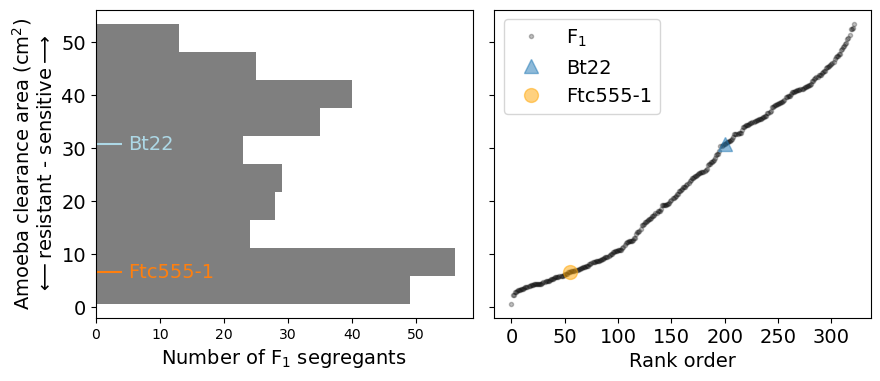

In [171]:
## Plot segregants
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)

plt.sca(ax[0])
## Plot all
plt.hist(Halo[(Halo.PMY.isin(Map_pop))].Halo.values,
         color='k',alpha=0.5,
         orientation='horizontal')
         
## Label x and y axis
plt.ylabel(myylabel,fontsize=14)
plt.xlabel('Number of F$_1$ segregants',fontsize=14);

## Plot parents

ftc555_growth = Halo[(Halo.PMY==Parent_PMY[1])].Halo
plt.hlines(ftc555_growth,
           0,4,color='tab:orange')

## annotate the parental strain name
plt.text(5,ftc555_growth,s=parents[1],
         va='center',ha='left',
         fontsize=14,color='tab:orange')


## Plot parents
bt22_growth = Halo[(Halo.PMY==Parent_PMY[0])].Halo
plt.hlines(bt22_growth,
           0,4,color='lightblue')
## annotate the parental strain name
plt.text(5,bt22_growth,s=parents[0],
         va='center',ha='left',
         fontsize=14,color='lightblue');

#plt.xticks(np.arange(0,25,5),fontsize=14)
plt.yticks(fontsize=14)
## Summon the legend
#plt.legend(fontsize=14);

plt.sca(ax[1])
Halo_sorted = Halo.sort_values('Halo').reset_index(drop=True)
Halo_sorted_seg = Halo_sorted[~(Halo_sorted.PMY.isin(Parent_PMY))]
plt.plot(Halo_sorted.index,
        Halo_sorted.Halo.values,
         'k.',alpha=0.25,label='F$_{1}$');



for i,p in enumerate(Parent_PMY):
    
    plt.plot(Halo_sorted[(Halo_sorted.PMY==p)].index,
               Halo_sorted[(Halo_sorted.PMY==p)].Halo.values,
         'o' if i ==1 else '^',alpha=0.5,label=parents[i],
             color='orange' if i == 1 else 'tab:blue',ms=10);
    
#for i,p in enumerate(poor_growth):
#    
#    plt.plot(Halo_sorted[(Halo_sorted.PMY==p)].index,
#               Halo_sorted[(Halo_sorted.PMY==p)].Halo.values,
#             '.',label=p,color='r',ms=12,alpha=0.58);
    
plt.xlabel('Rank order',fontsize=14);
plt.xticks(fontsize=14)
#plt.ylabel(myylabel,
#           fontsize=14)
plt.legend(fontsize=14);
plt.subplots_adjust(wspace=0.058)
plt.savefig('../../FIGURES/Bt22xFtc555-1_amoeba_assay.png',
            dpi=150,bbox_inches='tight');

In [172]:
parent_lab = ['Bt22', 'Ftc555-1']

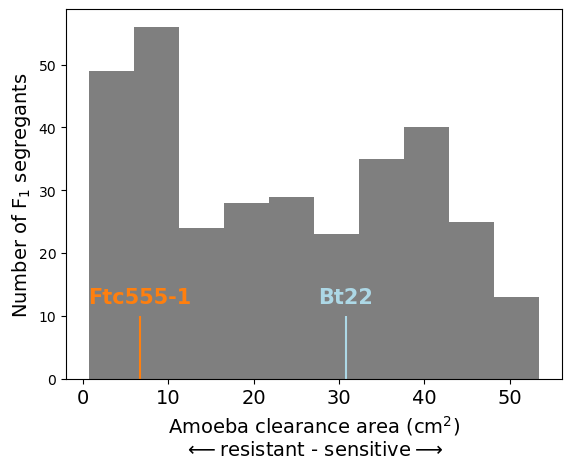

In [173]:
fs = 15

## Plot all
plt.hist(Halo[(Halo.PMY.isin(Map_pop))].Halo.values,
         color='k',alpha=0.5,
         orientation='vertical')
         
## Label x and y axis
plt.xlabel(myylabel,fontsize=14)
plt.ylabel('Number of F$_1$ segregants',fontsize=14);

## Plot parents
ftc555_growth = Halo[(Halo.PMY==Parent_PMY[1])].Halo
plt.vlines(ftc555_growth,
           0,10,color='tab:orange')

## annotate the parental strain name
plt.text(ftc555_growth,13,s=parent_lab[1],
         va='center',ha='center',
         fontsize=fs,color='tab:orange', fontweight='bold')

bt22_growth = Halo[(Halo.PMY==Parent_PMY[0])].Halo
plt.vlines(bt22_growth,
           0,10,color='lightblue')

## annotate the parental strain name
plt.text(bt22_growth,13,s=parent_lab[0],
         va='center',ha='center',
         fontsize=fs,color='lightblue', fontweight='bold');

plt.ticklabel_format(axis="x")
plt.xticks(fontsize=14);


plt.savefig('../../FIGURES/Bt220xFtc555-1_amoeba_assay_trim.png',
            dpi=150,bbox_inches='tight');

In [174]:
Halo.head()

,PMY,Replicate,Halo,Halo_in
PMY,,,,
PMY2649,PMY2649,2.041667,30.820458,4.777181
PMY2650,PMY2650,2.000000,6.688159,1.036667
PMY2556,PMY2556,1.500000,21.406409,3.318000
PMY2558,PMY2558,1.500000,7.051599,1.093000
PMY2559,PMY2559,1.500000,4.329024,0.671000


In [175]:
halo = Halo.loc[Map_pop]['Halo'].values
halo[:5]

array([30.82045807,  6.68815867, 21.4064088 ,  7.0515988 ,  4.3290236 ])

In [176]:
Halo.Halo.mean(), Halo.Halo.std()

(23.458729157160118, 14.98627754177948)

In [177]:
#pvaldf = QTLfun.QTLmap(geno,QTLfun.association_logPval,
#                         Map_pop,halo)

pvaldf = QTLfun.QTLmap(geno,QTLfun.allelic_manu,
                       Map_pop,halo)

In [178]:
aov_pvaldf = QTLfun.QTLmap(geno,QTLfun.association_logPval,
                       Map_pop,halo)

In [179]:
pvaldf.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940,QTL
0,1,25980,C.T,snp,25980,1.0,1.0,0.491857,1,0,...,1,1,0,1,0,1,1,0,0,0.118863
1,1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857,1,0,...,1,1,0,1,0,1,1,0,0,0.128030
2,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857,1,0,...,1,1,0,1,0,1,1,0,0,0.128030
3,1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857,1,0,...,1,1,0,1,0,1,1,0,0,0.128030
4,1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857,1,0,...,1,1,0,1,0,1,1,0,0,0.128030


In [180]:
pvaldf = pvaldf.sort_values(['Chrom','Pos']
                           ).reset_index(drop=True)

aov_pvaldf = aov_pvaldf.sort_values(['Chrom','Pos']
                           ).reset_index(drop=True)

In [181]:
chrommap = QTLfun.chrommap(pvaldf)
chrompad = np.cumsum(200000*np.ones(len(chrommap)))
chrommap['Cumlen'] = chrommap.Cumlen + chrompad
chrommap['Midpts'] = chrommap.Midpts + chrompad
chrommap.head()

,Chrom,Length,Cumlen,Midpts
0,1,2264002,200000.0,1332001.0
1,2,1619187,2664002.0,3473595.5
2,3,1554360,4483189.0,5260369.0
3,4,1059391,6237549.0,6767244.5
4,5,1793420,7496940.0,8393650.0


In [182]:
QTLix = pvaldf.QTL.idxmax()

In [183]:
perms = pd.read_csv('../../NOTES/Amoeba_halo_permutations.csv.gz',
                    names=['Null'])
perms.tail()

,Null
9996,4.096298
9997,3.724681
9998,2.845370
9999,3.576083
10000,2.971128


In [184]:
## Set significance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
threshold = 3.928068319177378## 0.05 threshold

## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = Halo.Halo.values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = geno[Map_pop].drop_duplicates() 

if threshold < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(association_logPval,
                               args=[perms_pheno[i]],
                               axis=1).max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold = np.percentile(null,95 if perms <= 1000 else 99)

In [185]:
## Set significance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
threshold_manu = 4.015902937573699## 0.05 threshold

## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = Halo.Halo.values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = geno[Map_pop].drop_duplicates() 

if threshold_manu < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(allelic_manu,
                               args=[perms_pheno[i]],
                               axis=1).max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold_manu = np.percentile(null,95 if perms <= 1000 else 99)

In [186]:
threshold_manu

4.015902937573699

In [187]:
#threshold = np.percentile(perms.Null.values,99)
#threshold

In [188]:
chrommap

,Chrom,Length,Cumlen,Midpts
0,1,2264002,200000.0,1332001.0
1,2,1619187,2664002.0,3473595.5
2,3,1554360,4483189.0,5260369.0
3,4,1059391,6237549.0,6767244.5
4,5,1793420,7496940.0,8393650.0
5,6,1417305,9490360.0,10199012.5
6,7,1374738,11107665.0,11795034.0
7,8,1387111,12682403.0,13375958.5
8,9,1155758,14269514.0,14847393.0
9,10,1051064,15625272.0,16150804.0


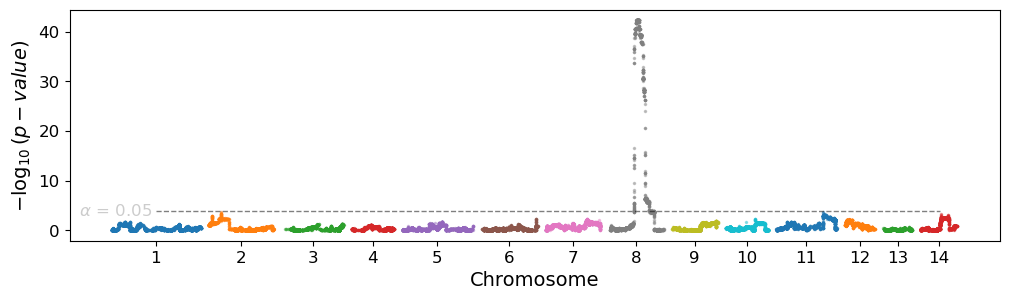

In [189]:
## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
fig.set_facecolor('w')
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values+cumpos,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
plt.hlines(threshold,chrommap.Midpts.min(),
           21*10**6,linewidth=1,alpha=0.5,
           linestyle='--',color='k')

plt.text(chrommap.Midpts.min()-100000,threshold,
         '$\u03B1$ = 0.05',
         fontsize=12,alpha=0.2,
         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.
#plt.ylim(0,10)
plt.savefig("../../FIGURES/Amoeba_Halo_QTL_manu_Bt22xFtc555-1.png",
            dpi = 200, bbox_inches = "tight") ## Save figure

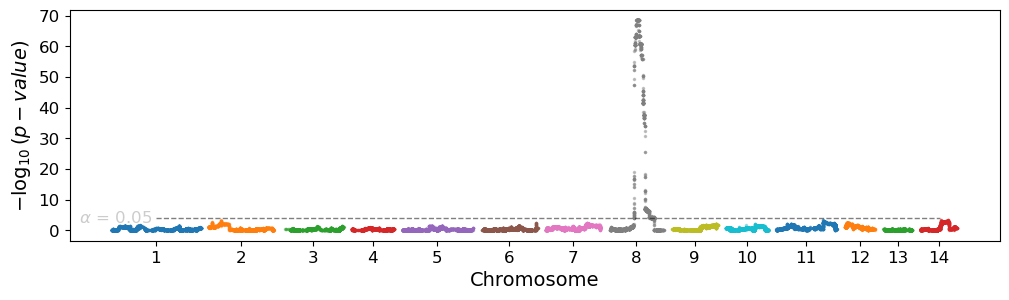

In [190]:
## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
fig.set_facecolor('w')
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = aov_pvaldf[(aov_pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values+cumpos,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
plt.hlines(threshold,chrommap.Midpts.min(),
           21*10**6,linewidth=1,alpha=0.5,
           linestyle='--',color='k')

plt.text(chrommap.Midpts.min()-100000,threshold,
         '$\u03B1$ = 0.05',
         fontsize=12,alpha=0.2,
         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.
#plt.ylim(0,10)
plt.savefig("../../FIGURES/Amoeba_Halo_QTL_log_Bt22xFtc555-1.png",
            dpi = 200, bbox_inches = "tight") ## Save figure

In [191]:
## Make a genotype by phenotype dataframe at QTL peak
## Find QTL idnex
#Qtl_ix = pvaldf.Pval.idxmax()

Qtl_ix = pvaldf.QTL.idxmax()

## Take genotype values and rename column
Qtl = pvaldf.loc[[Qtl_ix], sorted(Map_pop)].T
Qtl.columns = ["GT"]

## Find assocaited phenotypes view head
Qtl["Halo"] = Halo.loc[sorted(Map_pop), "Halo"].values
Qtl.head()

,GT,Halo
PMY2556,1.0,21.406409
PMY2558,1.0,7.051599
PMY2559,1.0,4.329024
PMY2560,1.0,3.896766
PMY2561,1.0,10.764495


In [192]:
import statsmodels.formula.api as smf, seaborn as sns

In [193]:
res = smf.ols('Halo~GT',data=Qtl).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Halo   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     523.2
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           2.68e-69
Time:                        11:31:32   Log-Likelihood:                -1172.1
No. Observations:                 322   AIC:                             2348.
Df Residuals:                     320   BIC:                             2356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.8847      0.718     48.608      0.000      33.473      36.297
GT           -23.5844      1.031    -22.873      0.000     -25.613     -21.556
==============================================================================
Omnibus:                       15.629   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.257
Skew:                           0.164   Prob(JB):                     2.21e-08
Kurtosis:                       4.587   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [194]:
## Make a genotype by phenotype dataframe at QTL peak
## Find QTL idnex
#Qtl_ix = pvaldf.Pval.idxmax()

Qtl_aov_ix = aov_pvaldf.QTL.idxmax()

## Take genotype values and rename column
Qtl_aov = pvaldf.loc[[Qtl_aov_ix], sorted(Map_pop)].T
Qtl_aov.columns = ["GT"]

## Find assocaited phenotypes view head
Qtl_aov["Halo"] = Halo.loc[sorted(Map_pop), "Halo"].values
Qtl_aov.head()

,GT,Halo
PMY2556,1.0,21.406409
PMY2558,1.0,7.051599
PMY2559,1.0,4.329024
PMY2560,1.0,3.896766
PMY2561,1.0,10.764495


In [195]:
res = smf.ols('Halo~GT',data=Qtl_aov).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Halo   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     523.2
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           2.68e-69
Time:                        11:31:32   Log-Likelihood:                -1172.1
No. Observations:                 322   AIC:                             2348.
Df Residuals:                     320   BIC:                             2356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.8847      0.718     48.608      0.000      33.473      36.297
GT           -23.5844      1.031    -22.873      0.000     -25.613     -21.556
==============================================================================
Omnibus:                       15.629   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.257
Skew:                           0.164   Prob(JB):                     2.21e-08
Kurtosis:                       4.587   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [196]:
myylabel = 'Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

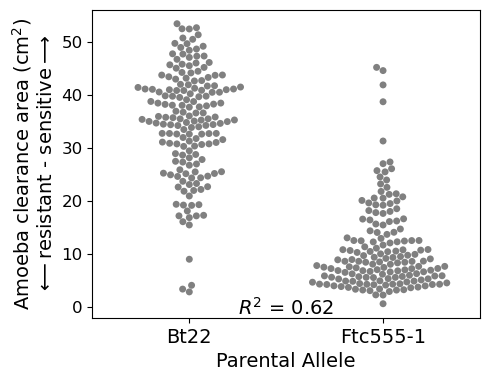

In [197]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
## Make a genotype by phenotype plot at QTL peak
## plto swarm
sns.swarmplot(x = "GT", y = "Halo", data = Qtl, color = "grey");
## plot regresison (we should remove this b/c we are not doing a regresson)
#sns.regplot(x = "GT", y = "Halo", data = Qtl, ci=False,
#            line_kws = {"alpha":0.8, "color":"red"}, 
#            scatter_kws = {"alpha":0});

plt.xticks([0,1], parents, fontsize = 14);
plt.yticks(fontsize = 12);
plt.xlabel("Parental Allele", fontsize = 14);
#plt.ylabel("Amoeba Clearance Area (cm$^2$)", fontsize = 14);
plt.ylabel(myylabel,fontsize=14)
plt.text(0.5,0,s='$R^2$ = 0.62',va='center',ha='center',fontsize=14)

plt.savefig("../../FIGURES/Amoeba_genotype_split_Chr8_Bt22xFtc555-1.png", 
            dpi = 100, bbox_inches = "tight")

Text(0.5, 0, '$R^2$ = 0.62')

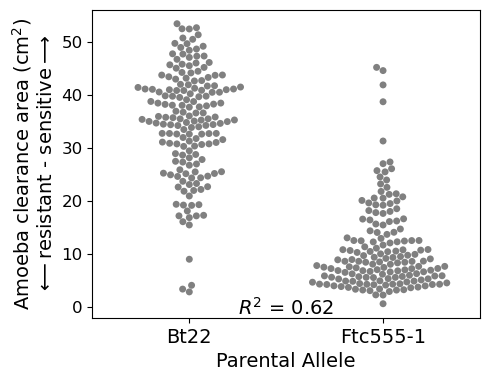

In [198]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
## Make a genotype by phenotype plot at QTL peak
## plto swarm
sns.swarmplot(x = "GT", y = "Halo", data = Qtl_aov, color = "grey");
## plot regresison (we should remove this b/c we are not doing a regresson)
#sns.regplot(x = "GT", y = "Halo", data = Qtl, ci=False,
#            line_kws = {"alpha":0.8, "color":"red"}, 
#            scatter_kws = {"alpha":0});

plt.xticks([0,1], parents, fontsize = 14);
plt.yticks(fontsize = 12);
plt.xlabel("Parental Allele", fontsize = 14);
#plt.ylabel("Amoeba Clearance Area (cm$^2$)", fontsize = 14);
plt.ylabel(myylabel,fontsize=14)
plt.text(0.5,0,s='$R^2$ = 0.62',va='center',ha='center',fontsize=14)

#plt.savefig("C:/Users/tsauters/Pictures/scientific figures/Amoeba_genotype_split_Chr8_Bt22xFtc555-1.png", 
#            dpi = 100, bbox_inches = "tight")

In [199]:
a = Qtl[Qtl.Halo == Qtl.Halo.max()].index

b = Qtl[Qtl.Halo == Qtl.Halo.min()].index

Qtl.loc[a], Qtl.loc[b]

(          GT       Halo
 PMY2646  0.0  53.490216,
           GT      Halo
 PMY2626  1.0  0.660214)

In [200]:
## What is the max clearance
## It cannot be more than 58 cm2
Qtl.Halo.max()

53.49021559999999

In [201]:
## sub divide and reconduct QTL mappin
Map_pop0 = Qtl[(Qtl.GT == 0)].index.tolist()
Map_pop1 =Qtl[(Qtl.GT == 1)].index.tolist()

## View number of progeny in each group
len(Map_pop0), len(Map_pop1)

(166, 156)

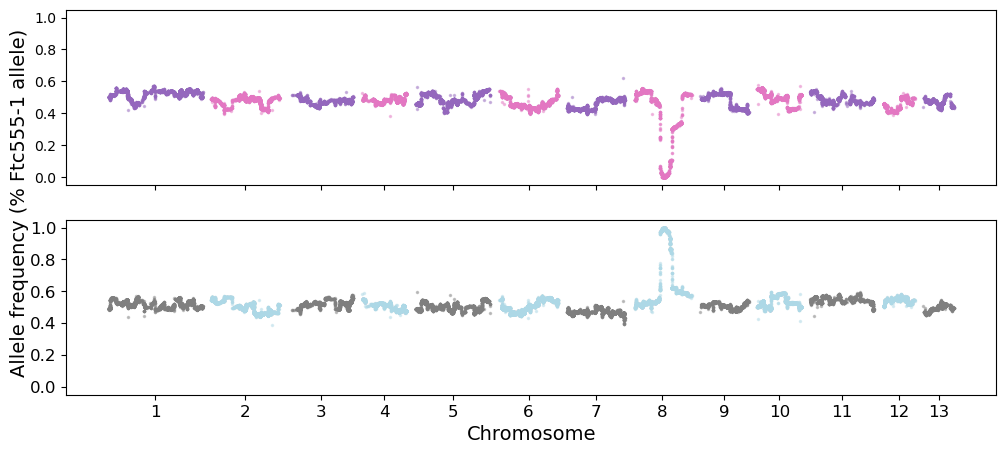

In [202]:
## Plot results of split (based on allele at QTL 8) QTL analysis
fig,ax = plt.subplots(2,1,figsize=(12,5), 
                      sharex = True, sharey = True) ## Makes a figure instance
for i,j in chrommap[:-1].iterrows(): ## For ech row in dataframe chrommap do this ...    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.sca(ax[0]) ## For Bt22 progeny
    plt.plot(temp.Pos.values+cumpos,
             temp[Map_pop0].mean(axis=1),
             '.',markersize=3,alpha=0.4,
             color='tab:purple' if i%2==0 else 'tab:pink'); ## plots the data x vs y

    
    plt.sca(ax[1]) ## For Ftc555-1 progeny
    plt.plot(temp.Pos.values+cumpos,
             temp[Map_pop1].mean(axis=1),
             '.',markersize=3,alpha=0.4,
            color='tab:grey' if i%2==0 else 'lightblue'); ## plots the data x vs y
    
plt.sca(ax[0])
plt.ylabel('Allele frequency (% Ftc555-1 allele)',fontsize=14,y=-0.1)
plt.sca(ax[1])
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:-1], chrommap.Chrom[:-1],
           fontsize=12); ## set location, labels and fontsize of x tics.

#plt.savefig("../../FIGURES/Amoeba_Halo_Allele_Freq_split_Bt22xFtc555-1.png", 
#            dpi = 200, bbox_inches = "tight")

In [203]:
geno.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2931,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940
Oldindex,,,,,,,,,,,,,,,,,,,,,
5,1,25980,C.T,snp,25980,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
7,1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
12,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
15,1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
17,1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0


In [204]:
## For sub population with Bt22 allele at QTL
## conduct QTL mapping and merge results
## taking just p-value column
loci0 = geno[(geno.Chrom != 8)][sorted(Map_pop0)].drop_duplicates()
loci0['Pval'] = loci0.apply(allelic_manu, 
                            args=[Halo.loc[sorted(Map_pop0), "Halo"]], 
                            axis=1)
pvaldf["Pval0"] = geno.merge(loci0, how = 'left')["Pval"].replace(np.inf,np.nan)

In [205]:
## For sub population with Ftc555-1 allele at QTL
## conduct QTL mapping and merge results
## taking just p-value column
loci1 = geno[(geno.Chrom != 8)][sorted(Map_pop1)].drop_duplicates()

#loci1 = loci1[~(loci1.index.isin(pvaldf[(pvaldf.Pval1>10)].index))]
loci1['Pval'] = loci1.apply(allelic_manu, 
                            args=[Halo.loc[sorted(Map_pop1), "Halo"]], 
                            axis=1)

pvaldf["Pval1"] = geno.merge(loci1, how = 'left')["Pval"].replace(np.inf,np.nan)

In [206]:
pvaldf.loc[pvaldf.Pval1.idxmax()]

Chrom             5
Pos         1016048
Alleles         C.T
Type            snp
Newpos      1016048
             ...   
PMY2939           1
PMY2940           0
QTL        1.087544
Pval0      1.612242
Pval1      8.184187
Name: 17255, Length: 333, dtype: object

In [207]:
## view head of new p-values
pvaldf.head()[['QTL','Pval0','Pval1']]

,QTL,Pval0,Pval1
0,0.118863,0.170958,0.131465
1,0.128030,0.082930,0.133767
2,0.128030,0.082930,0.133767
3,0.128030,0.082930,0.133767
4,0.128030,0.082930,0.133767


In [208]:
## Set significance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
threshold_sub = 3.9539422633919585 ## 0.05 threshold

## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = Halo.loc[sorted(Map_pop1),'Halo'].values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = geno[(geno.Chrom != 8)][sorted(Map_pop1)].drop_duplicates() 

if threshold_sub < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(allelic_manu,
                               args=[perms_pheno[i]],
                               axis=1).replace(np.inf,np.nan).dropna().max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold_sub = np.percentile(null,95 if perms <= 1000 else 99)

In [209]:
threshold_sub

3.9539422633919585

In [210]:
## Set significance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
threshold_sub0 = 4.112760965400148 ## 0.05 threshold

## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = Halo.loc[sorted(Map_pop0),'Halo'].values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = geno[(geno.Chrom != 8)][sorted(Map_pop0)].drop_duplicates()

if threshold_sub0 < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(allelic_manu,
                               args=[perms_pheno[i]],
                               axis=1).replace(np.inf,np.nan).dropna().max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold_sub0 = np.percentile(null,95 if perms <= 1000 else 99)

In [211]:
threshold_sub0

4.112760965400148

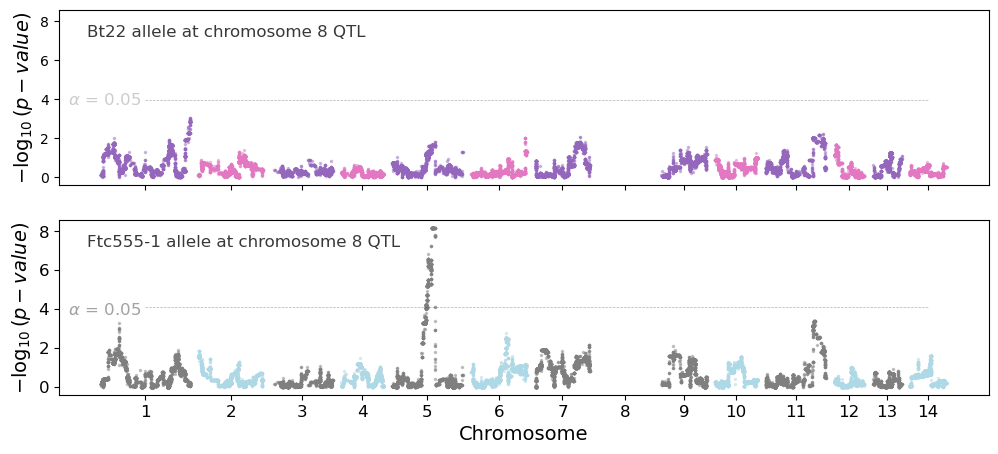

In [212]:
## Plot results of split (based on allele at QTL 8) QTL analysis
fig,ax = plt.subplots(2,1,figsize=(12,5), 
                      sharex = True, sharey = True) ## Makes a figure instance
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap do this ...    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.sca(ax[0]) ## For Bt22 progeny
    #plt.hlines(threshold_sub,0,19*10**6,alpha=0.5,
    #           linestyle='--',linewidth=1,color='k')
    plt.plot(temp.Pos.values+cumpos,temp.Pval0.values,
             '.',markersize=3,alpha=0.4,
             color='tab:purple' if i%2==0 else 'tab:pink'); ## plots the data x vs y

    
    plt.sca(ax[1]) ## For Ftc555-1 progeny

    
    
    plt.plot(temp.Pos.values+cumpos,temp.Pval1.values,
             '.',markersize=3,alpha=0.4,
            color='tab:grey' if i%2==0 else 'lightblue'); ## plots the data x vs y
    
for i in [0,1]:
    plt.sca(ax[i])
    plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
    plt.title("%s allele at chromosome 8 QTL"%parents[i], 
              x = .03, y = .8, ha = "left",fontsize=12,alpha=0.78)
    
    if i == 0:     
        plt.hlines(threshold_sub,chrommap.Midpts.min(),
               21*10**6,alpha=0.3,
                   linestyle='--',linewidth=0.5,color='k')
        plt.text(chrommap.Midpts.min()-100000,threshold_sub,
             '$\u03B1$ = 0.05',
                 fontsize=12,alpha=0.2,ha='right',va='center')
        
    else: 
        plt.hlines(threshold_sub0,chrommap.Midpts.min(),
               21*10**6,alpha=0.3,
                   linestyle='--',linewidth=0.5,color='k')
        plt.text(chrommap.Midpts.min()-100000,threshold_sub,
             '$\u03B1$ = 0.05',
                 fontsize=12,alpha=0.2,ha='right',va='center')
    

plt.text(chrommap.Midpts.min()-100000,threshold_sub,
             '$\u03B1$ = 0.05',
         fontsize=12,alpha=0.2,ha='right',va='center')

plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.

plt.savefig("../../FIGURES/Amoeba_Halo_manu_QTL_split_Bt22xFtc555-1.png", 
            dpi = 200, bbox_inches = "tight")

In [213]:
## Bring in bootstraps for QTL5
boots_chr5_path = '../../NOTES/Amoeba_halo_bootstraps_chr5.csv.gz'
boots_chr5 = pd.read_csv(boots_chr5_path)
boots_chr5.head()

,Median,Mean,Min,Max,Pval
0,1107243.0,1.107243e+06,1107188,1107298,7.303787
1,1037151.0,1.049044e+06,1016048,1106918,9.026382
2,1029405.0,1.043072e+06,1016048,1101798,9.111332
3,1107243.0,1.107243e+06,1107188,1107298,5.814647
4,1029405.0,1.043072e+06,1016048,1101798,7.312121


In [214]:
## Sub set qtl 5 data
qtl5 = pvaldf[(pvaldf.Chrom==5)]

In [215]:
qtl5max = qtl5[(qtl5.Pval1==qtl5.Pval1.max())]
qtl5_l,qtl5_r = qtl5max.Pos.min(),qtl5max.Pos.max()
qtl5_l,qtl5_r

(1016048, 1101798)

In [216]:
qtl5max.Pval1.max()

8.184186692903676

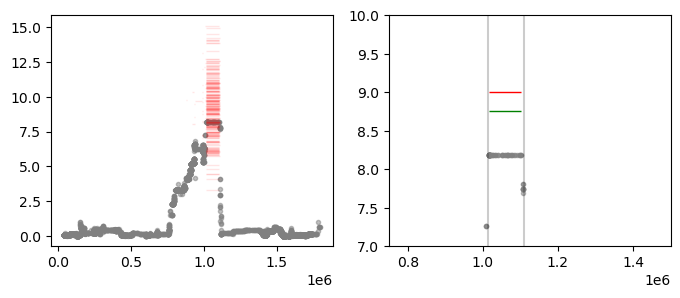

In [217]:
## Plot chromosome 5 QTL and CI
fig,ax = plt.subplots(1,2,figsize=(8,3))
plt.sca(ax[0])


## Plot qtl on chr. 5
plt.plot(qtl5.Pos,qtl5.Pval1,'.',color='grey',alpha=0.5);

## plot CI
[plt.hlines(j.Pval,j.Min,j.Max,color='r',
            alpha=0.1,linewidth=1) 
 for i,j in boots_chr5.iterrows()];

plt.sca(ax[1])

plt.plot(qtl5.Pos,qtl5.Pval1,'.',color='grey',alpha=0.5);

cil = boots_chr5.Min.median()
cir = boots_chr5.Max.median()

plt.hlines(9,cil,cir,color='r',linewidth=1)
plt.hlines(8.75,qtl5_l,qtl5_r,color='g',linewidth=1)

plt.vlines((1015000,1110000),7,10,color='k',alpha=0.2)

plt.ylim(7,10);plt.xlim(750000,1500000);

In [218]:
qtl5[(qtl5.Pval1==qtl5.Pval1.max())].Pos.min()

1016048

In [219]:
qtl5[(qtl5.Pval1==qtl5.Pval1.max())].Pos.max()

1101798

In [220]:
## Gather information on chromosome 5 QTL
QTL5_ix = qtl5.Pval1.idxmax()
QTL5_gt = pvaldf.loc[QTL5_ix,:][Map_pop]
Qtl['QTL5'] = QTL5_gt
Qtl['Chromosome 5 QTL'] = Qtl['QTL5'].replace(dict(zip([0,1],parents)))
Qtl.head()

,GT,Halo,QTL5,Chromosome 5 QTL
PMY2556,1.0,21.406409,0,Bt22
PMY2558,1.0,7.051599,0,Bt22
PMY2559,1.0,4.329024,1,Ftc555-1
PMY2560,1.0,3.896766,1,Ftc555-1
PMY2561,1.0,10.764495,0,Bt22


In [221]:
## Set ylabel
myylabel = 'Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

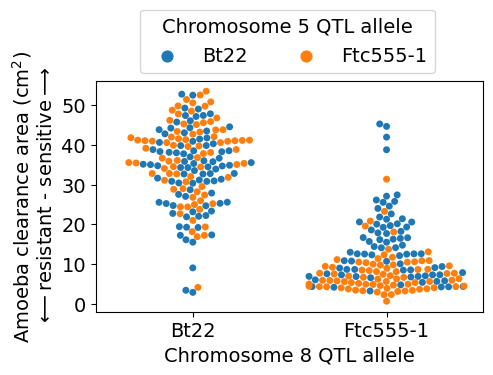

In [222]:
fig,ax = plt.subplots(1,1,figsize=(5,3),sharey=True)
sns.swarmplot(x='GT',y='Halo',
              data=Qtl,hue='Chromosome 5 QTL')

plt.xticks([0,1],parents,fontsize=14)
plt.xlabel('Chromosome 8 QTL allele',fontsize=14)
lg = plt.legend(fontsize=14,bbox_to_anchor=(.9,1.35),ncol=2,
           title='Chromosome 5 QTL allele')
lg.get_title().set_fontsize(14)
plt.ylabel(myylabel,fontsize=14)
plt.yticks(fontsize=14);
#plt.savefig('../../FIGURES/Amoeba_Halo_by_genotype_QTL5_Bt22xFtc555-1.png',
#           dpi=100,bbox_inches='tight');

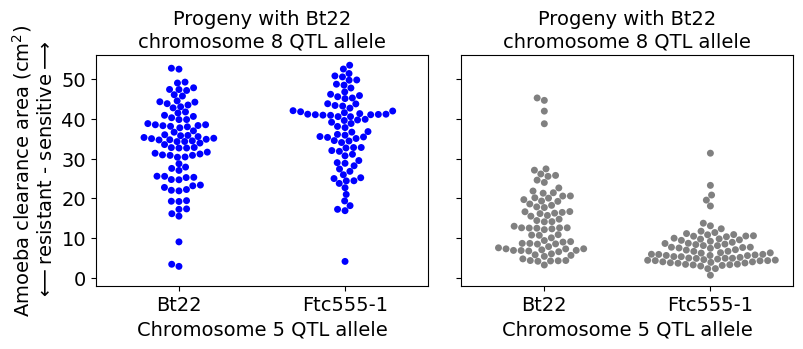

In [223]:
fig,ax = plt.subplots(1,2,figsize=(9,3),sharey=True)
plt.sca(ax[0])
sns.swarmplot(x='QTL5',y='Halo',
              data=Qtl[(Qtl.GT==0)],
              color='blue')

plt.title('Progeny with Bt22\nchromosome 8 QTL allele',fontsize=14)
plt.xticks([0,1],parents,fontsize=14)
plt.xlabel('Chromosome 5 QTL allele',fontsize=14)

plt.ylabel(myylabel,fontsize=14)
plt.yticks(fontsize=14);

plt.sca(ax[1])
sns.swarmplot(x='QTL5',y='Halo',
              data=Qtl[(Qtl.GT==1)],
              color='grey')

plt.title('Progeny with Bt22\nchromosome 8 QTL allele',fontsize=14)
plt.xticks([0,1],parents,fontsize=14)
plt.xlabel('Chromosome 5 QTL allele',fontsize=14)

plt.ylabel(' ',fontsize=14)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('../../FIGURES/Amoeba_Halo_by_genotype_splits_Bt22xFtc555-1.png',
#           dpi=100,bbox_inches='tight');

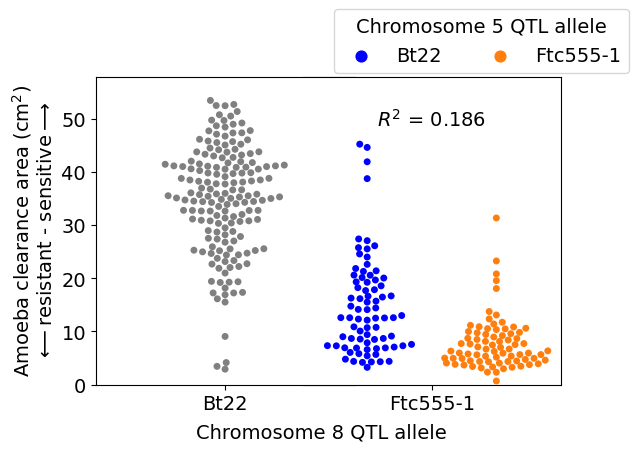

In [224]:
fig,ax = plt.subplots(1,2,figsize=(6,4),sharey=False)
plt.sca(ax[0])
sns.swarmplot(x='GT',
              y='Halo',data=Qtl[(Qtl.GT==0)],size=5,
             color='grey')
plt.xlabel(' ')
plt.xticks([0],['Bt22'],fontsize=14)
plt.ylabel(myylabel, fontsize = 14);
plt.yticks(fontsize=14)
plt.ylim(0,58)
plt.sca(ax[1])
sns.swarmplot(x='Chromosome 5 QTL',
              y='Halo',data=Qtl[(Qtl.GT==1)],
              hue='Chromosome 5 QTL',size=5,
              palette=dict(zip(parents,['blue','tab:orange'])))
plt.xlabel(' ');plt.ylabel(' ')

ax[1].spines['left'].set_visible(False)
#ax.spines['top'].set_visible(False)

plt.xticks([0.5],['Ftc555-1'],fontsize=14);
plt.yticks([])
fig.text(x=0.5,y=-0.01,s='Chromosome 8 QTL allele',
         fontsize=14,va='center',ha='center')
lg = plt.legend(fontsize=14,bbox_to_anchor=(1.3,1.25),ncol=2,
           title='Chromosome 5 QTL allele')
lg.get_title().set_fontsize(14)
plt.ylim(0,58)
plt.subplots_adjust(wspace=-.2)
plt.text(0.5,50,s='$R^2$ = 0.186',va='center',ha='center',fontsize=14)

plt.savefig("../../FIGURES/Amoeba_by_genotype_split_Chr5_Bt22xFtc555-1.png", 
                       dpi = 200, bbox_inches = "tight")

In [225]:
Qtl.Halo.max(),Qtl.Halo.min()

(53.49021559999999, 0.6602137333333333)

In [226]:
centlocs = pd.read_csv('../../NOTES/H99_Vikas_Centromere_locations.csv',index_col=0)
centlocs.head()

,L,R
0,970169,1006931
1,835384,889427
2,1370568,1409632
3,708804,752337
4,1559983,1587231


In [227]:
boots = pd.read_csv('../../NOTES/Amoeba_halo_bootstraps.csv.gz')
boots.sort_values('Pval',inplace=True)
boots.head()

,Median,Mean,Min,Max,Pval
291,729668.0,730488.688889,694583,757311,35.414171
55,731678.0,731195.474227,694185,759761,35.513326
285,733961.5,734437.512500,694583,757311,36.163890
397,729668.0,730488.688889,694583,757311,36.341953
129,733035.0,733944.703704,694520,757311,36.343976


In [228]:
boots.shape

(500, 5)

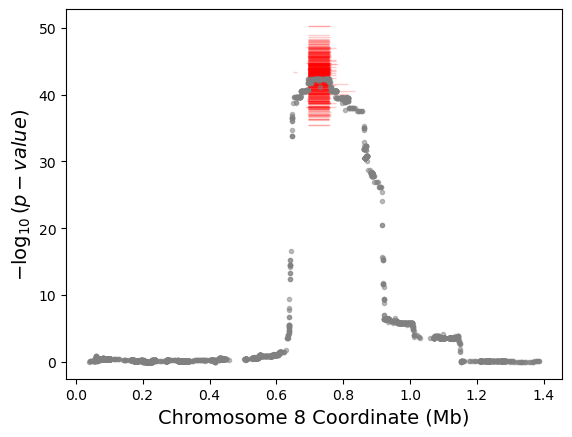

In [229]:
for k,(i,b) in enumerate(boots.iterrows()):
    
    plt.hlines(b.Pval,b.Min,b.Max,
               color='r',alpha=0.2,linewidth=1)
    
qtl8 = pvaldf[(pvaldf.Chrom==8)]

#plt.vlines(boots.Max.mean(),38,42,color='g')
plt.plot(qtl8.Pos.values,qtl8.QTL.values,
         '.',color='grey',alpha=0.5);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome 8 Coordinate (Mb)',fontsize=14);
#plt.vlines(boots.Max.mean(),35,45,color='g')
#plt.vlines(boots.Min.mean(),35,45,color='g')

p,l = plt.xticks()
plt.xticks(p[1:-1],p[1:-1]/(10**6));
#plt.savefig('../../FIGURES/Amoeba_Halo_QTL_CI.png',
#            dpi=100,bbox_inches='tight');

In [230]:
## Make a copy of just chormosome 8 results
qtl8 = pvaldf[(pvaldf.Chrom==8)].copy()

In [231]:
pvaldf

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940,QTL,Pval0,Pval1
0,1,25980,C.T,snp,25980,1.0,1.0,0.491857,1,0,...,0,1,0,1,1,0,0,0.118863,0.170958,0.131465
1,1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857,1,0,...,0,1,0,1,1,0,0,0.128030,0.082930,0.133767
2,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857,1,0,...,0,1,0,1,1,0,0,0.128030,0.082930,0.133767
3,1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857,1,0,...,0,1,0,1,1,0,0,0.128030,0.082930,0.133767
4,1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857,1,0,...,0,1,0,1,1,0,0,0.128030,0.082930,0.133767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46755,14,915487,GTGCG.ATGCG.GTGTG,snp,915487,14.0,14.0,0.472313,0,1,...,0,1,1,1,1,1,0,0.760066,0.505351,0.206856
46756,14,918283,A.G,snp,918283,14.0,14.0,0.472313,0,1,...,0,1,1,1,1,1,0,0.760066,0.505351,0.206856
46757,14,923437,TAGA.CAGA,snp,923437,14.0,14.0,0.472313,0,1,...,0,1,1,1,1,1,0,0.760066,0.505351,0.206856
46758,14,925335,C.G,snp,925335,14.0,14.0,0.472313,0,1,...,0,1,1,1,1,1,0,0.760066,0.505351,0.206856


In [232]:
## Find the QTL plateau
plat = pvaldf[(pvaldf.Chrom==8) & (pvaldf.QTL>=pvaldf.QTL.max())]
plat_left,plat_right = plat.Pos.min(),plat.Pos.max()

In [233]:
to_correct = pvaldf[(pvaldf.Chrom==8) & 
       (pvaldf.Pos>=plat_left) & 
       (pvaldf.Pos<=plat_right) & (pvaldf.QTL>30)]

In [234]:
to_correct[(to_correct.QTL<pvaldf.QTL.max())]

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940,QTL,Pval0,Pval1
29325,8,694988,A.C,snp,694988,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29326,8,695068,C.T,snp,695068,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29327,8,695520,TT.CT,snp,695520,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29328,8,695606,GAAGA.AAAGA,snp,695606,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29329,8,697057,A.G,snp,697057,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29330,8,698842,C.T,snp,698842,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29331,8,701723,A.T,snp,701723,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29332,8,702560,GTA.ATA,snp,702560,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29333,8,703618,T.C,snp,703618,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN
29334,8,703999,CCT.TCT.GCC,snp,703999,8.0,8.0,0.472313,1,1,...,0,0,0,1,1,1,1,41.771591,NaN,NaN


In [235]:
## For initial analysis set the left and right sides of QTL
left,right = 650000,850000

In [236]:
co = qtl8[(qtl8.Pos>=left) & (qtl8.Pos<=right)][Map_pop].diff(axis=0).abs().sum()
qtl_recombs = co[(co>0)].index.tolist()
len(qtl_recombs)

28

In [237]:
qtl_recombs_sorted = Halo[(Halo.PMY.isin(qtl_recombs))
                         ].sort_values('Halo').PMY.tolist()

In [238]:
#qtl_genes = pd.read_csv('../../NOTES/QTL_gene_analysis.csv')
qtl_genes = pd.read_csv('../../NOTES/Bt22xFtc555-1_gene_analysis.1.2.3.5.6.8.10.11.csv.gz')
qtl_genes.tail()

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand
8435,NaN,CNAG_07747,CNAG_07747-t26_1,712.0,NaN,NaN,1,1,0,0,0,0,0,0,8,acyl-CoA oxidase,1309584,1312923,1
8436,NaN,CNAG_07748,CNAG_07748-t26_1,423.0,NaN,NaN,1,1,0,0,0,0,0,0,8,tRNA (uracil-5-)-methyltransferase TRM9,1321587,1323175,-1
8437,NaN,CNAG_07751,CNAG_07751-t26_1,611.0,NaN,NaN,1,1,0,0,0,0,0,0,8,siderophore iron transporter mirB,1359863,1362381,-1
8438,NaN,CNAG_07993,CNAG_07993-t26_1,99.0,NaN,NaN,1,1,0,0,0,0,0,0,8,hypothetical protein,27173,28211,1
8439,NaN,CNAG_07996,CNAG_07996-t26_1,404.0,NaN,NaN,1,1,0,0,0,0,0,0,8,hypothetical protein,1337362,1339177,1


In [239]:
boots.Min.mean(),boots.Max.mean()

(695170.708, 759311.694)

In [240]:
qtl8_ci_genes = qtl_genes[(qtl_genes.Chrom==8) & 
                  (qtl_genes.End>=boots.Min.mean()-1000) & 
                  (qtl_genes.Start <= boots.Max.mean()+1000)]

qtl5_ci_genes = qtl_genes[(qtl_genes.Chrom==5) & 
                  (qtl_genes.End>=qtl5[(qtl5.Pval1>=qtl5.Pval1.max())].Pos.min()-1000) & 
                  (qtl_genes.Start<=qtl5[(qtl5.Pval1>=qtl5.Pval1.max())].Pos.max()+1000)]

In [241]:
qtl8_ci_genes.drop_duplicates().shape,qtl5_ci_genes.shape

((53, 19), (55, 19))

In [242]:
qtl8_names = pd.read_csv('../../NOTES/QTL8_amoeba_gene_names.csv')
qtl8_names.head()

,Gene,Name
0,CNAG_03342,TRM82
1,CNAG_03345,SSD1
2,CNAG_03347,ClpB
3,CNAG_03349,prp17
4,CNAG_03355,TCO4


In [243]:
qtl5_names = pd.read_csv('../../NOTES/QTL5_amoeba_gene_names.csv',header=None)
qtl5_names.columns=['Gene','Name']
qtl5_names.head()

,Gene,Name
0,CNAG_01155,GUT1
1,CNAG_01170,S17
2,CNAG_01165,LCB5
3,CNAG_01159,SLU7
4,CNAG_01156,CAP2


In [244]:
qtl8_ci_genes.head()

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand
7889,PMY2649,CNAG_03342,CNAG_03342-t26_1,569.0,569.0,569.0,1,1,3,5,0,0,4,1,8,tRNA (guanine-N(7)-)-methyltransferase subunit...,692706,694766,1
7890,PMY2650,CNAG_03342,CNAG_03342-t26_1,569.0,569.0,569.0,1,1,0,2,0,0,1,1,8,tRNA (guanine-N(7)-)-methyltransferase subunit...,692706,694766,1
7891,PMY2649,CNAG_03343,CNAG_03343-t26_1,232.0,232.0,232.0,1,1,1,3,0,0,1,2,8,hypothetical protein,694724,696026,-1
7892,PMY2650,CNAG_03343,CNAG_03343-t26_1,232.0,232.0,232.0,1,1,0,1,0,0,1,0,8,hypothetical protein,694724,696026,-1
7893,PMY2649,CNAG_03344,CNAG_03344-t26_1,380.0,380.0,380.0,1,1,1,1,0,0,1,0,8,hypothetical protein,696160,698711,1


In [245]:
## For QTL 8
qtl8_unique_genes_ci = qtl8_ci_genes.groupby('Gene').agg('max').sort_values('Nonsyn').reset_index()

names = []
for i,j in qtl8_unique_genes_ci.iterrows():
    if j.Gene in qtl8_names.Gene.tolist():
        gn = qtl8_names[(qtl8_names.Gene==j.Gene)].Name.min()
    else:
        gn = j.Gene
    names.append(gn)

qtl8_unique_genes_ci['Name'] = names


## For QTL 5
qtl5_unique_genes_ci = qtl5_ci_genes.groupby('Gene').agg('max').sort_values('Nonsyn').reset_index()

names = []
for i,j in qtl5_unique_genes_ci.iterrows():
    if j.Gene in qtl5_names.Gene.tolist():
        gn = qtl5_names[(qtl5_names.Gene==j.Gene)].Name.min()
    else:
        gn = j.Gene
    names.append(gn)

qtl5_unique_genes_ci['Name'] = names

qtl8_unique_genes_ci.shape,qtl5_unique_genes_ci.shape

((24, 20), (33, 20))

In [246]:
qtl5_unique_genes_ci.head()

,Gene,Strain,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand,Name
0,CNAG_01138,NaN,CNAG_01138-t26_1,378.0,NaN,NaN,1,1,0,0,0,0,0,0,5,cytochrome c peroxidase,1101942,1103697,1,CCP1
1,CNAG_01171,PMY2650,CNAG_01171-t26_1,102.0,102.0,102.0,1,1,0,1,0,1,0,0,5,hypothetical protein,1015508,1016189,1,CNAG_01171
2,CNAG_01170,PMY2650,CNAG_01170-t26_1,143.0,143.0,143.0,1,1,0,7,0,1,0,6,5,small subunit ribosomal protein S17,1016102,1017337,-1,S17
3,CNAG_01168,PMY2650,CNAG_01168-t26_1,503.0,503.0,503.0,1,1,0,2,0,1,1,0,5,H/ACA ribonucleoprotein complex subunit 4,1019136,1021259,-1,CNAG_01168
4,CNAG_01165,NaN,CNAG_01165-t26_1,566.0,NaN,NaN,1,1,0,0,0,0,0,0,5,D-erythro-sphingosine kinase,1027395,1030070,1,LCB5


In [247]:
qtl8_unique_genes_ci[
    (qtl8_unique_genes_ci.Description!='hypothetical protein')
     ].sort_values('Gene')

,Gene,Strain,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand,Name
23,CNAG_03342,PMY2650,CNAG_03342-t26_1,569.0,569.0,569.0,1,1,3,5,0,0,4,1,8,tRNA (guanine-N(7)-)-methyltransferase subunit...,692706,694766,1,TRM82
3,CNAG_03345,PMY2650,CNAG_03345-t26_2,1670.0,1670.0,1670.0,1,1,0,4,2,1,1,2,8,putative translational repressor,696583,704402,-1,SSD1
4,CNAG_03346,NaN,CNAG_03346-t26_1,342.0,NaN,NaN,1,1,0,0,0,0,0,0,8,bZip transcription factor,706174,708222,-1,BZP4
12,CNAG_03347,PMY2650,CNAG_03347-t26_1,834.0,834.0,834.0,1,1,1,1,0,1,1,0,8,ATP-dependent Clp protease ATP-binding subunit...,711064,713892,-1,ClpB
7,CNAG_03349,PMY2650,CNAG_03349-t26_1,615.0,615.0,615.0,1,1,0,3,1,2,1,0,8,pre-mRNA-processing factor 17,718250,721408,-1,prp17
10,CNAG_03355,PMY2650,CNAG_03355-t26_1,1838.0,1838.0,1838.0,1,1,1,6,0,1,2,3,8,Two-component-like sensor kinase,730288,738294,1,TCO4
2,CNAG_03358,PMY2650,CNAG_03358-t26_1,417.0,417.0,417.0,1,1,0,1,0,0,0,1,8,Phosphoglycerate kinase,742046,744593,-1,PGK
1,CNAG_03359,PMY2650,CNAG_03359-t26_1,57.0,57.0,57.0,1,1,0,1,0,1,0,0,8,cytochrome c oxidase subunit 7,744190,744760,1,COX7
20,CNAG_03366,PMY2650,CNAG_03366-t26_2,738.0,738.0,738.0,1,1,2,10,4,0,5,1,8,C2H2 type zinc finger transcription factor,755992,763369,1,ZNF2
18,CNAG_07724,PMY2650,CNAG_07724-t26_1,1048.0,1048.0,1048.0,1,1,2,5,0,1,5,0,8,Metal-binding regulatory protein CUF1,721568,725406,-1,CUF1


In [248]:
qtl8_unique_genes_ci = qtl8_unique_genes_ci.replace("ClpB", "HSP78")

In [249]:
cds = gff[(gff.Type=='CDS')].copy()
cds['ParentN'] = [int(a[-1]) for a in cds.Parent.values]

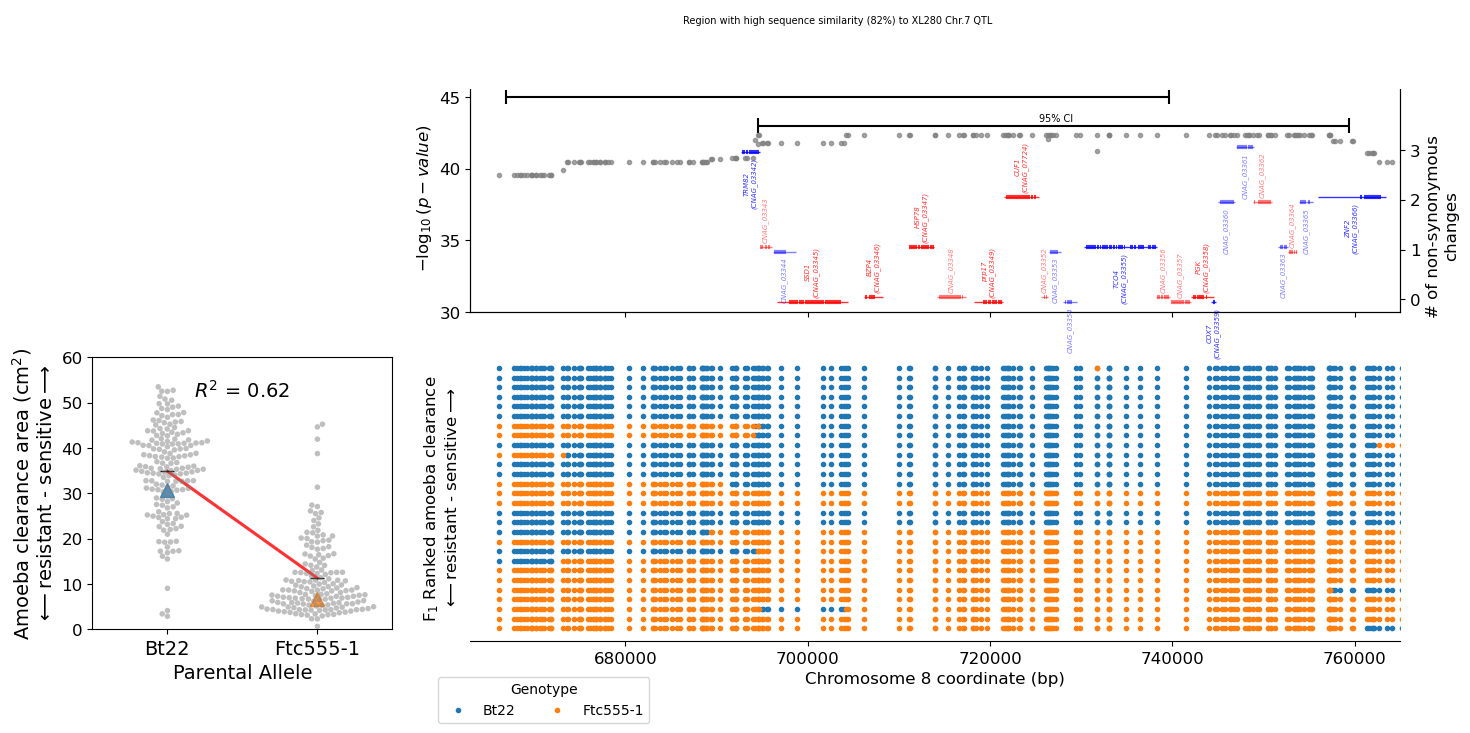

In [250]:
newylabel = 'F$_1$ Ranked amoeba clearance\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

qtl8 = pvaldf[(pvaldf.Chrom==8)].copy()
fig,ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
plt.sca(ax[0])


## Add annottion of sequence similarity
xl280y = np.round(pvaldf.QTL.max())+3
plt.text(np.mean([666895,739631]),50,
         s='Region with high sequence similarity (82%) to XL280 Chr.7 QTL',
         ha='center',va='bottom',fontsize=7,color='k')
plt.hlines(xl280y,666895,739631,color='k');
[plt.vlines(k,xl280y-.5,
            xl280y+.5,
            color='k') for k in [666895,739631]]

## annotate
ciy = np.round(pvaldf.QTL.max())+1
plt.vlines(boots.Max.mean(),ciy-0.5,ciy+0.5,color='k')
plt.vlines(to_correct.Pos.min(),ciy-0.5,ciy+0.5,color='k')
plt.hlines(ciy,to_correct.Pos.min(),boots.Max.mean(),
          color='k')
plt.text(np.mean([boots.Min.mean(),boots.Max.mean()]),ciy+0.5,
        '95% CI',color='k',fontsize=7,
         va='center',ha='center')

#qtl8.drop(to_correct[(to_correct.Pval<pvaldf.Pval.max())].index,
#         axis=0,inplace=True)
plt.plot(qtl8.Pos.values,qtl8.QTL.values,
         '.',color='grey',alpha=0.7);
plt.ylim(30,50)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12,y=0.4) ## Add x label.
plt.yticks(np.arange(30,50,5),fontsize=12)

plt.xlim(660000,780000)


ax[0].spines['top'].set_visible(False)

ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis

ax1.spines['top'].set_visible(False)
plt.sca(ax1)

plt.ylabel('# of non-synonymous\nchanges',fontsize=12,y=0.3)

for i,j in qtl8_unique_genes_ci.iterrows():
    ygm = 0.051 if i%2==0 else -0.051
    plt.hlines(j.Nonsyn+ygm,
               j.Start,j.End,
               color='blue' if j.Strand > 0 else 'red',
               alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
              linewidth=1);
    
    cdsg = cds[(cds.Gene==j.Gene) & (cds.ParentN==int(j.Parent[-1]))]
    
    for z,l in cdsg.iterrows():
        plt.hlines(j.Nonsyn+ygm,l.Start,l.End,
                   color='blue' if j.Strand > 0 else 'red',
                   alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
                  linewidth=3)
    
    gene_name = '%s\n(%s)'%(j.Name,j.Gene) if j.Name!=j.Gene else j.Gene
    plt.text(np.mean([j.Start,j.End]),
             j.Nonsyn+ygm + (0.1 if j.Strand<0 else -0.1),
             #j.Nonsyn+ygm+(0.1 if j.Name==j.Gene else (0 if (j.Strand<0) else -0.3)),
             s = gene_name,
             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
             fontstyle='italic',
             color='blue' if j.Strand>0 else 'red',
             #fontsize=8 if j.Name != j.Gene else 4,
             fontsize=5,
             va='bottom' if j.Strand<0 else 'top',
             #rotation = 90 if j.Name == j.Gene else 0,
             rotation = 90,
             ha='center')
          
plt.ylim(-.25,5.5) 
plt.yticks(np.arange(qtl8_unique_genes_ci.Nonsyn.max()+1),
           fontsize=12)
plt.xlim(660000,780000)

plt.sca(ax[1])
for i,j in enumerate(qtl_recombs_sorted):
    
    haplo = pvaldf[(pvaldf.Chrom==8)]
    
    bt22 = haplo[(haplo[j])==0].Pos.values
    ftc5 = haplo[(haplo[j])==1].Pos.values
    
    plt.plot(bt22,(i+1)*np.ones(len(bt22)),'.',
             color='tab:blue',label='Bt22' if i == 0 else None)
    plt.plot(ftc5,(i+1)*np.ones(len(ftc5)),'.',
             color='tab:orange',label='Ftc555-1' if i == 0 else None)
plt.legend(bbox_to_anchor=(0.2,-0.1),ncol=2,title='Genotype')
[ax[1].spines[ts].set_visible(False) for ts in ['top','left','right']]
plt.xlim(left-1000,right+1000);
plt.subplots_adjust(hspace=0.081);
plt.ylabel(newylabel,fontsize=12)
plt.yticks([])
plt.xticks(fontsize=12)
plt.xlabel('Chromosome 8 coordinate (bp)',fontsize=12);
plt.xlim(663000,765000)
ws = fig.add_axes([0.051,0.8,.1,.1])
[ws.spines[ts].set_visible(False) 
 for ts in ['top','bottom','left','right']]
plt.xticks([]);plt.yticks([])

ws = fig.add_axes([0.85,0.8,.1,.1])
[ws.spines[ts].set_visible(False) 
 for ts in ['top','bottom','left','right']]
plt.xticks([]);plt.yticks([])

plt.subplots_adjust(hspace=0.15)

axcoords = [-0.19,0.125,0.25,0.34]

axp = fig.add_axes(axcoords)

sns.swarmplot(x = "GT", y = "Halo", 
              data = Qtl, color = "grey",
              size=4,alpha=0.5);
sns.regplot(x = "GT", y = "Halo", data = Qtl, ci=False,
            line_kws = {"alpha":0.8, "color":"red"}, 
            scatter_kws = {"alpha":0});

plt.xticks([0,1], parents, fontsize = 14);
plt.yticks(fontsize = 12);
plt.xlabel("Parental Allele", fontsize = 14);
plt.ylabel(myylabel,fontsize=14)
plt.title(x=0.5,y=0.85,label='$R^2$ = 0.62',
         va='center',ha='center',fontsize=14)

plt.plot(Qtl.groupby('GT').mean().index,
         Qtl.groupby('GT').mean().Halo,
         'k_',markersize=10)


[plt.plot(Qtl.loc[p].GT,
         Qtl.loc[p].Halo,'^',
          color = 'tab:blue' if i == 0 else 'tab:orange',
          alpha=0.8,markersize=10,
        ) for i,p in enumerate(Parent_PMY)]
plt.ylim(0,60);

#plt.savefig('../../FIGURES/Amoeba_Halo_QTL_8_%s_%s_kb_Haplotype_Map.pdf'%(int(to_correct.Pos.min()/1000),int(boots.Max.mean()/1000)),
#            dpi=300,bbox_inches='tight')

(663000.0, 765000.0)

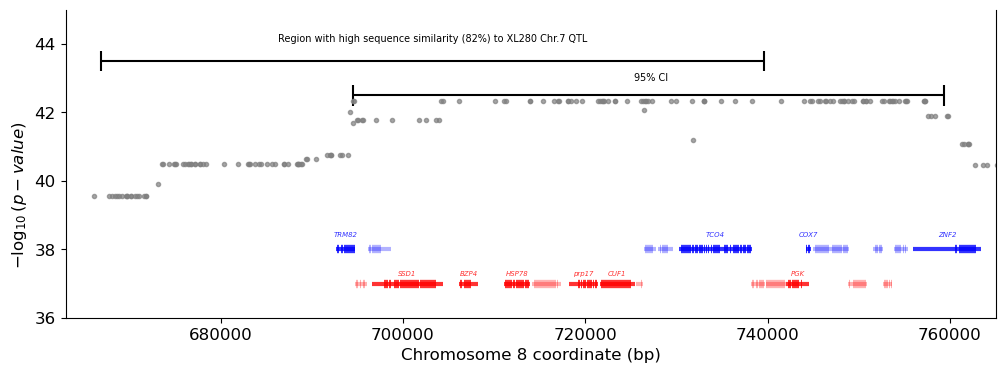

In [251]:
newylabel = 'F$_1$ Ranked amoeba clearance\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

qtl8 = pvaldf[(pvaldf.Chrom==8)].copy()
fig,ax = plt.subplots(1,1,figsize=(12,4),sharex=True)
plt.sca(ax)


## Add annottion of sequence similarity
xl280y = np.round(pvaldf.QTL.max())+1.5
plt.text(np.mean([666895,739631]), xl280y + .5,
         s='Region with high sequence similarity (82%) to XL280 Chr.7 QTL',
         ha='center',va='bottom',fontsize=7,color='k')
plt.hlines(xl280y,666895,739631,color='k');
[plt.vlines(k,xl280y-.3,
            xl280y+.3,
            color='k') for k in [666895,739631]]

## annotate
ciy = np.round(pvaldf.QTL.max())+.5
plt.vlines(boots.Max.mean(),ciy-0.3,ciy+0.3,color='k')
plt.vlines(to_correct.Pos.min(),ciy-0.3,ciy+0.3,color='k')
plt.hlines(ciy,to_correct.Pos.min(),boots.Max.mean(),
          color='k')
plt.text(np.mean([boots.Min.mean(),boots.Max.mean()]),ciy+0.5,
        '95% CI',color='k',fontsize=7,
         va='center',ha='center')

#qtl8.drop(to_correct[(to_correct.Pval<pvaldf.Pval.max())].index,
#         axis=0,inplace=True)
plt.plot(qtl8.Pos.values,qtl8.QTL.values,
         '.',color='grey',alpha=0.7);
plt.ylim(36,45)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12,y=0.4) ## Add x label.
#plt.yticks(np.arange(36,46,2),fontsize=12)
plt.yticks([36, 38, 40, 42, 44], fontsize = 12)

ax.spines['top'].set_visible(False)

for i,j in qtl8_unique_genes_ci.iterrows():
    ygm = 38 if j.Strand > 0 else 37
    plt.hlines(ygm,
               j.Start,j.End,
               color='blue' if j.Strand > 0 else 'red',
               alpha = 0.3 if j.Description == 'hypothetical protein' else 0.8,
              linewidth=3);
    
    cdsg = cds[(cds.Gene==j.Gene) & (cds.ParentN==int(j.Parent[-1]))]
    
    for z,l in cdsg.iterrows():
        plt.hlines(ygm,l.Start,l.End,
                   color='blue' if j.Strand > 0 else 'red',
                   alpha = 0.3 if j.Description == 'hypothetical protein' else 0.8,
                  linewidth=6)
        
#        gene_name = '%s\n(%s)'%(j.Name,j.Gene) if j.Name!=j.Gene else j.Gene
#    plt.text(np.mean([j.Start,j.End]),
#             ygm + (0.25 if j.Strand<0 else 0.75),
#             s = gene_name,
#             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
#             fontstyle='italic',
#             color='blue' if j.Strand>0 else 'red',
#             #fontsize=8 if j.Name != j.Gene else 4,
#             fontsize=5,
#             va='bottom' if j.Strand<0 else 'top',
#              rotation = 0,
#             ha='center')

        gene_name = j.Name if j.Name!=j.Gene else ' '
    plt.text(np.mean([j.Start,j.End]),
             ygm + (0.2 if j.Strand<0 else 0.5),
             s = gene_name,
             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
             fontstyle='italic',
             color='blue' if j.Strand>0 else 'red',
             #fontsize=8 if j.Name != j.Gene else 4,
             fontsize=5,
             va='bottom' if j.Strand<0 else 'top',
             #rotation = 90 if j.Name == j.Gene else 0,
             rotation = 0,
             ha='center')
    
plt.xticks(fontsize=12)
plt.xlabel('Chromosome 8 coordinate (bp)',fontsize=12);
plt.xlim(663000,765000)

#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/QTL_overlap.png", 
#                       dpi = 200, bbox_inches = "tight")

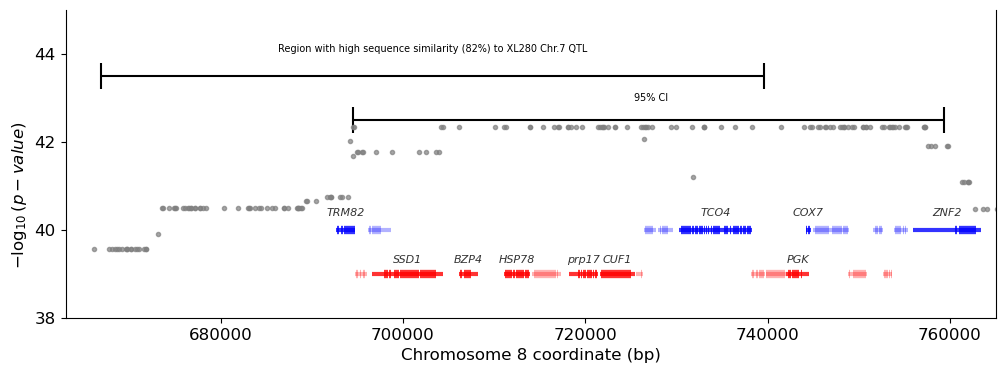

In [252]:
newylabel = 'F$_1$ Ranked amoeba clearance\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

qtl8 = pvaldf[(pvaldf.Chrom==8)].copy()
fig,ax = plt.subplots(1,1,figsize=(12,4),sharex=True)
plt.sca(ax)


## Add annottion of sequence similarity
xl280y = np.round(pvaldf.QTL.max())+1.5
plt.text(np.mean([666895,739631]), xl280y + .5,
         s='Region with high sequence similarity (82%) to XL280 Chr.7 QTL',
         ha='center',va='bottom',fontsize=7,color='k')
plt.hlines(xl280y,666895,739631,color='k');
[plt.vlines(k,xl280y-.3,
            xl280y+.3,
            color='k') for k in [666895,739631]]

## annotate
ciy = np.round(pvaldf.QTL.max())+.5
plt.vlines(boots.Max.mean(),ciy-0.3,ciy+0.3,color='k')
plt.vlines(to_correct.Pos.min(),ciy-0.3,ciy+0.3,color='k')
plt.hlines(ciy,to_correct.Pos.min(),boots.Max.mean(),
          color='k')
plt.text(np.mean([boots.Min.mean(),boots.Max.mean()]),ciy+0.5,
        '95% CI',color='k',fontsize=7,
         va='center',ha='center')

#qtl8.drop(to_correct[(to_correct.Pval<pvaldf.Pval.max())].index,
#         axis=0,inplace=True)
plt.plot(qtl8.Pos.values,qtl8.QTL.values,
         '.',color='grey',alpha=0.7);
plt.ylim(38,45)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12,y=0.4) ## Add x label.
#plt.yticks(np.arange(36,46,2),fontsize=12)
plt.yticks([38, 40, 42, 44], fontsize = 12)

ax.spines['top'].set_visible(False)

for i,j in qtl8_unique_genes_ci.iterrows():
    ygm = 40 if j.Strand > 0 else 39
    plt.hlines(ygm,
               j.Start,j.End,
               color='blue' if j.Strand > 0 else 'red',
               alpha = 0.3 if j.Description == 'hypothetical protein' else 0.8,
              linewidth=3);
    
    cdsg = cds[(cds.Gene==j.Gene) & (cds.ParentN==int(j.Parent[-1]))]
    
    for z,l in cdsg.iterrows():
        plt.hlines(ygm,l.Start,l.End,
                   color='blue' if j.Strand > 0 else 'red',
                   alpha = 0.3 if j.Description == 'hypothetical protein' else 0.8,
                  linewidth=6)
        

        gene_name = j.Name if j.Name!=j.Gene else ' '
    plt.text(np.mean([j.Start,j.End]),
             ygm + (0.2 if j.Strand<0 else 0.5),
             s = gene_name,
             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
             fontstyle='italic',
             #fontsize=8 if j.Name != j.Gene else 4,
             fontsize=8,
             va='bottom' if j.Strand<0 else 'top',
             #rotation = 90 if j.Name == j.Gene else 0,
             rotation = 0,
             ha='center')
    
plt.xticks(fontsize=12)
plt.xlabel('Chromosome 8 coordinate (bp)',fontsize=12);
plt.xlim(663000,765000)

plt.savefig("../../FIGURES/QTL_overlap.png", 
                       dpi = 200, bbox_inches = "tight")

In [253]:
cds

,Seqid,Source,Type,Start,End,Score,Strand,Phase,Attribute,Parent,Gene,Chrom,Length,Cumpos,Midpts,ParentN
6,CP003824.1,EuPathDB,CDS,409667,410051,.,1,0,ID=CNAG_01397-t26_1-p1-CDS1;Parent=CNAG_01397-...,CNAG_01397-t26_1,CNAG_01397,5,1814975,6573120,7480607.5,1
7,CP003824.1,EuPathDB,CDS,410113,410259,.,1,2,ID=CNAG_01397-t26_1-p1-CDS2;Parent=CNAG_01397-...,CNAG_01397-t26_1,CNAG_01397,5,1814975,6573120,7480607.5,1
8,CP003824.1,EuPathDB,CDS,410314,410424,.,1,2,ID=CNAG_01397-t26_1-p1-CDS3;Parent=CNAG_01397-...,CNAG_01397-t26_1,CNAG_01397,5,1814975,6573120,7480607.5,1
9,CP003824.1,EuPathDB,CDS,410484,410566,.,1,2,ID=CNAG_01397-t26_1-p1-CDS4;Parent=CNAG_01397-...,CNAG_01397-t26_1,CNAG_01397,5,1814975,6573120,7480607.5,1
24,CP003824.1,EuPathDB,CDS,573160,573475,.,-1,1,ID=CNAG_01334-t26_1-p1-CDS8;Parent=CNAG_01334-...,CNAG_01334-t26_1,CNAG_01334,5,1814975,6573120,7480607.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133996,CP003834.1,EuPathDB,CDS,5482,6189,.,1,0,ID=CNAG_09003-t26_1-p1-CDS1;Parent=CNAG_09003-...,CNAG_09003-t26_1,CNAG_09003,15,24919,18891193,18903652.5,1
134003,CP003834.1,EuPathDB,CDS,725,1291,.,1,0,ID=CNAG_09001-t26_1-p1-CDS1;Parent=CNAG_09001-...,CNAG_09001-t26_1,CNAG_09001,15,24919,18891193,18903652.5,1
134010,CP003834.1,EuPathDB,CDS,21963,23462,.,1,0,ID=CNAG_09010-t26_1-p1-CDS1;Parent=CNAG_09010-...,CNAG_09010-t26_1,CNAG_09010,15,24919,18891193,18903652.5,1
134023,CP003834.1,EuPathDB,CDS,9654,10493,.,1,0,ID=CNAG_09004-t26_1-p1-CDS1;Parent=CNAG_09004-...,CNAG_09004-t26_1,CNAG_09004,15,24919,18891193,18903652.5,1


In [254]:
qtl8_unique_genes_ci

,Gene,Strain,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand,Name
0,CNAG_03352,PMY2650,CNAG_03352-t26_1,91.0,91.0,91.0,1,1,0,1,0,0,0,1,8,hypothetical protein,725534,726325,-1,CNAG_03352
1,CNAG_03359,PMY2650,CNAG_03359-t26_1,57.0,57.0,57.0,1,1,0,1,0,1,0,0,8,cytochrome c oxidase subunit 7,744190,744760,1,COX7
2,CNAG_03358,PMY2650,CNAG_03358-t26_1,417.0,417.0,417.0,1,1,0,1,0,0,0,1,8,Phosphoglycerate kinase,742046,744593,-1,PGK
3,CNAG_03345,PMY2650,CNAG_03345-t26_2,1670.0,1670.0,1670.0,1,1,0,4,2,1,1,2,8,putative translational repressor,696583,704402,-1,SSD1
4,CNAG_03346,NaN,CNAG_03346-t26_1,342.0,NaN,NaN,1,1,0,0,0,0,0,0,8,bZip transcription factor,706174,708222,-1,BZP4
5,CNAG_03357,PMY2650,CNAG_03357-t26_1,612.0,612.0,612.0,1,1,0,1,0,0,0,1,8,hypothetical protein,739822,742000,-1,CNAG_03357
6,CNAG_03348,PMY2650,CNAG_03348-t26_1,811.0,811.0,811.0,1,1,0,4,2,0,2,0,8,hypothetical protein,714123,717304,-1,CNAG_03348
7,CNAG_03349,PMY2650,CNAG_03349-t26_1,615.0,615.0,615.0,1,1,0,3,1,2,1,0,8,pre-mRNA-processing factor 17,718250,721408,-1,prp17
8,CNAG_03356,PMY2650,CNAG_03356-t26_1,350.0,350.0,350.0,1,1,0,1,0,1,0,0,8,hypothetical protein,738180,739704,-1,CNAG_03356
9,CNAG_03354,PMY2650,CNAG_03354-t26_1,211.0,211.0,211.0,1,1,0,1,0,1,0,0,8,hypothetical protein,728019,729581,1,CNAG_03354


In [255]:
gene_8_check = qtl_genes[(qtl_genes.Chrom==8) & 
                         (qtl_genes.Start>=qtl8_unique_genes_ci.Start.min()) &
                         (qtl_genes.End<=qtl8_unique_genes_ci.End.max())]
len(gene_8_check.Gene.unique())

24

In [256]:
len([g for g in gene_8_check.Gene.unique().tolist() 
 if g not in qtl8_unique_genes_ci.Gene.unique().tolist() ])

0

In [257]:
g = qtl8_unique_genes_ci.Gene.unique()[0]

In [258]:
qtl_genes[(qtl_genes.Gene==g)]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand
7905,PMY2649,CNAG_03352,CNAG_03352-t26_1,91.0,91.0,91.0,1,1,0,0,0,0,0,0,8,hypothetical protein,725534,726325,-1
7906,PMY2650,CNAG_03352,CNAG_03352-t26_1,91.0,91.0,91.0,1,1,0,1,0,0,0,1,8,hypothetical protein,725534,726325,-1


In [259]:
savecsvpath = '../../NOTES/Amoeba_Halo_QTL_8_Haplotype_Genes.csv'
qtl8_genes = qtl_genes[(qtl_genes.Gene.isin(qtl8_unique_genes_ci.Gene))
         ].sort_values(['Start','Nonsyn'])
qtl8_genes.to_csv(savecsvpath)

In [260]:
qtl8_genes_uni = qtl8_genes[['Gene','Chrom','Start','End',
                             'Nvars','Nonsyn','Description','Strand']
                           ].groupby('Gene').agg('max')

qtl8_genes_uni.to_csv('../../NOTES/Amoeba_Halo_QTL_8_Haplotype_Genes_Unique.csv')

In [261]:
qtl8_genes.to_csv('../../NOTES/Amoeba_Halo_QTL_8_Haplotype_Genes_by_Strain.csv')

In [262]:
qtl8_genes[(qtl8_genes.Altstop>1)]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand


In [263]:
qtl8_genes_uni.shape

(24, 7)

In [264]:
qtl8_genes_uni[(qtl8_genes_uni.Description!='hypothetical protein')].shape

(10, 7)

In [265]:
qtl8_genes_uni.head()

,Chrom,Start,End,Nvars,Nonsyn,Description,Strand
Gene,,,,,,,
CNAG_03342,8,692706,694766,5,3,tRNA (guanine-N(7)-)-methyltransferase subunit...,1
CNAG_03343,8,694724,696026,3,1,hypothetical protein,-1
CNAG_03344,8,696160,698711,1,1,hypothetical protein,1
CNAG_03345,8,696583,704402,4,0,putative translational repressor,-1
CNAG_03346,8,706174,708222,0,0,bZip transcription factor,-1


In [266]:
Qtl['QTL5'] = Qtl['QTL5'].apply(float)

In [267]:
Map_pop1[:5]

['PMY2556', 'PMY2558', 'PMY2559', 'PMY2560', 'PMY2561']

In [268]:
Qtl[(Qtl.GT==1)].index[:5]

Index(['PMY2556', 'PMY2558', 'PMY2559', 'PMY2560', 'PMY2561'], dtype='object')

In [269]:
qtl5_unique_genes_ci

,Gene,Strain,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand,Name
0,CNAG_01138,NaN,CNAG_01138-t26_1,378.0,NaN,NaN,1,1,0,0,0,0,0,0,5,cytochrome c peroxidase,1101942,1103697,1,CCP1
1,CNAG_01171,PMY2650,CNAG_01171-t26_1,102.0,102.0,102.0,1,1,0,1,0,1,0,0,5,hypothetical protein,1015508,1016189,1,CNAG_01171
2,CNAG_01170,PMY2650,CNAG_01170-t26_1,143.0,143.0,143.0,1,1,0,7,0,1,0,6,5,small subunit ribosomal protein S17,1016102,1017337,-1,S17
3,CNAG_01168,PMY2650,CNAG_01168-t26_1,503.0,503.0,503.0,1,1,0,2,0,1,1,0,5,H/ACA ribonucleoprotein complex subunit 4,1019136,1021259,-1,CNAG_01168
4,CNAG_01165,NaN,CNAG_01165-t26_1,566.0,NaN,NaN,1,1,0,0,0,0,0,0,5,D-erythro-sphingosine kinase,1027395,1030070,1,LCB5
5,CNAG_01164,PMY2650,CNAG_01164-t26_1,706.0,706.0,706.0,1,1,0,1,0,0,1,1,5,glutamine-fructose-6-phosphate transaminase (i...,1029583,1033747,-1,CNAG_01164
6,CNAG_01162,PMY2650,CNAG_01162-t26_1,345.0,345.0,345.0,1,1,0,2,1,1,0,0,5,hypothetical protein,1039748,1041583,-1,CNAG_01162
7,CNAG_01161,NaN,CNAG_01161-t26_1,277.0,NaN,NaN,1,1,0,0,0,0,0,0,5,hypothetical protein,1041687,1043338,1,CNAG_01161
8,CNAG_01159,NaN,CNAG_01159-t26_1,574.0,NaN,NaN,1,1,0,0,0,0,0,0,5,pre-mRNA-splicing factor slu7,1046983,1049114,-1,SLU7
9,CNAG_01157,PMY2650,CNAG_01157-t26_1,481.0,481.0,481.0,1,1,0,1,0,1,0,0,5,hypothetical protein,1052187,1054534,-1,CNAG_01157


(0.0, 60.0)

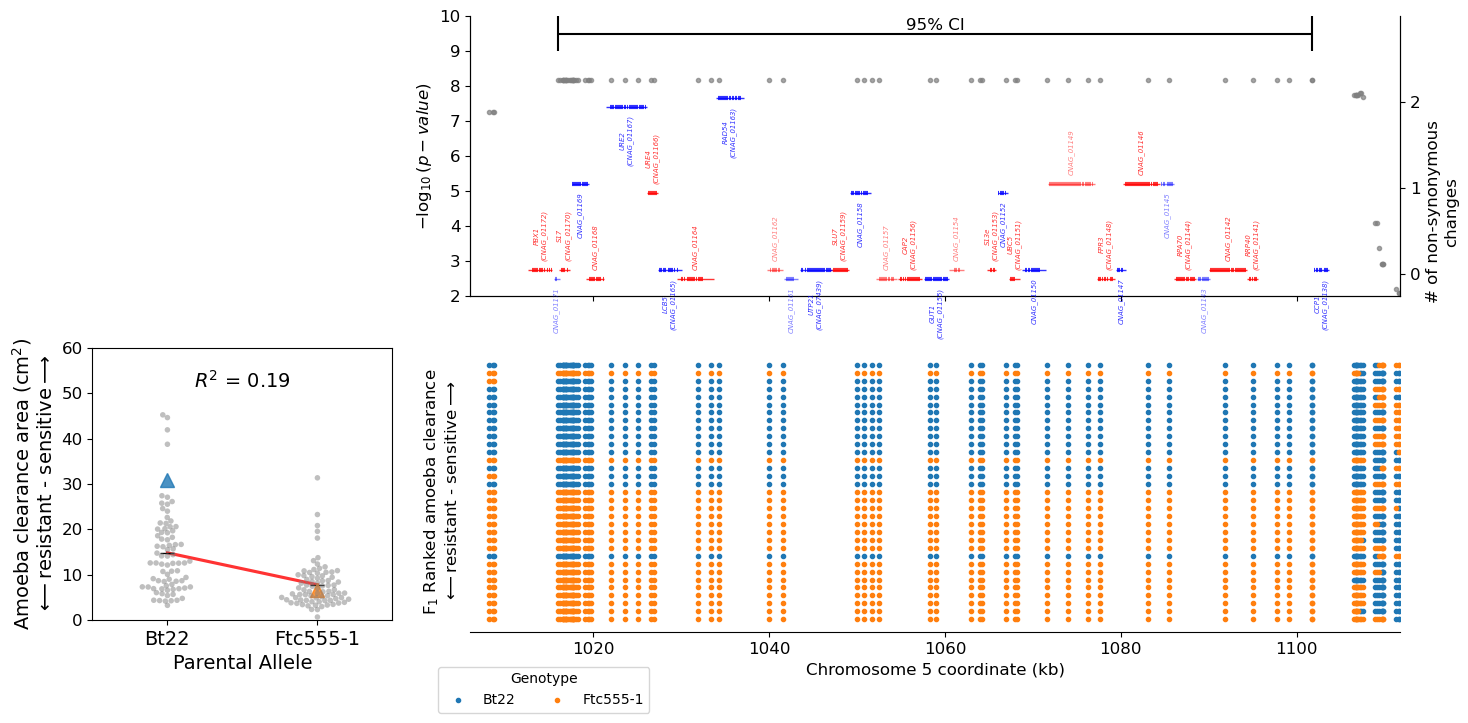

In [270]:
co_perseg = qtl5[(qtl5.Pos>=qtl5_l-10000) & 
                 (qtl5.Pos<=qtl5_r+10000)][Map_pop1
                        ].diff(axis=0).abs().sum(axis=0)

co5_segs = co_perseg[(co_perseg>0)].index

co5_segs_sorted = Qtl.loc[co5_segs].sort_values('Halo').index.tolist()

qtl5 = pvaldf[(pvaldf.Chrom==5) & 
              (pvaldf.Pos>=qtl5_l-10000) & 
              (pvaldf.Pos<=qtl5_r+10000) & 
              (pvaldf.Pval1>=2)
             ].copy()
fig,ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
plt.sca(ax[0])


## Plot chromosome 5 QTL
plt.plot(qtl5.Pos.values,qtl5.Pval1.values,
         '.',color='grey',alpha=0.7);
plt.ylim(2,10)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12,y=0.5) ## Add x label.
plt.yticks(fontsize=12)
plt.xlim(qtl5_l+10000,qtl5_r+10000);

## Plot QTL 5 CI
ymod = 1.5
ciy = np.round(qtl5.Pval1.max()) + ymod 
cil = qtl5[(qtl5.Pval1>=qtl5.Pval1.max())].Pos.min()#boots_chr5.Min.mean()
cir = qtl5[(qtl5.Pval1>=qtl5.Pval1.max())].Pos.max()#boots_chr5.Max.mean()

plt.hlines(ciy,cil,cir,color='k')
plt.vlines(cil,ciy-0.5,ciy+0.5,color='k')
plt.vlines(cir,ciy-0.5,ciy+0.5,color='k');
plt.text(np.mean([cil,cir]),ciy,'95% CI',
         fontsize=12,ha='center',va='bottom')

ax[0].spines['top'].set_visible(False)
ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
ax1.spines['top'].set_visible(False)
plt.sca(ax1)
plt.ylabel('# of non-synonymous\nchanges',fontsize=12,y=0.3)
for i,j in qtl5_unique_genes_ci.iterrows():
    ygm = 0.051 if i%2==0 else -0.051
    plt.hlines(j.Nonsyn+ygm,
               j.Start,j.End,
               color='blue' if j.Strand > 0 else 'red',
               alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
              linewidth=1);
    
    cdsg = cds[(cds.Gene==j.Gene) & (cds.ParentN==int(j.Parent[-1]))]
    
    for z,l in cdsg.iterrows():
        plt.hlines(j.Nonsyn+ygm,l.Start,l.End,
                   color='blue' if j.Strand > 0 else 'red',
                   alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
                  linewidth=3)
    
    
    gene_name = '%s\n(%s)'%(j.Name,j.Gene) if j.Name!=j.Gene else j.Gene
    plt.text(np.mean([j.Start,j.End]),
             j.Nonsyn+ygm + (0.1 if j.Strand<0 else -0.1),
             s = gene_name,
             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
             fontstyle='italic',
             color='blue' if j.Strand>0 else 'red',
             fontsize=5,
             va='bottom' if j.Strand<0 else 'top',
             rotation = 90,
             ha='center')
          
plt.ylim(-.25,3) 
plt.yticks(np.arange(qtl5_unique_genes_ci.Nonsyn.max()+1),
           fontsize=12)

## Plot recombinant progeny
plt.sca(ax[1])
for i,j in enumerate(co5_segs_sorted):
    
    haplo = qtl5
    
    bt22 = haplo[(haplo[j])==0].Pos.values
    ftc5 = haplo[(haplo[j])==1].Pos.values
    
    plt.plot(bt22,(i+1)*np.ones(len(bt22)),'.',
             color='tab:blue',label='Bt22' if i == 0 else None)
    plt.plot(ftc5,(i+1)*np.ones(len(ftc5)),'.',
             color='tab:orange',label='Ftc555-1' if i == 0 else None)
plt.legend(bbox_to_anchor=(0.2,-0.1),ncol=2,title='Genotype')
[ax[1].spines[ts].set_visible(False) for ts in ['top','left','right']]

plt.yticks([])
plt.ylabel(newylabel,fontsize=12)
plt.xlim(qtl5_l-10000,qtl5_r+10000);
xs,ps = plt.xticks()

plt.xticks(xs[1:-1],[int(x/1000) for x in xs[1:-1]], fontsize=12)
plt.xlabel('Chromosome 5 coordinate (kb)',fontsize=12);

axcoords = [-0.19,0.125,0.25,0.34]

axp = fig.add_axes(axcoords)

qtl5r2 = np.round(ss.pearsonr(Qtl[(Qtl.GT==1)].QTL5.values,
            Qtl[(Qtl.GT==1)].Halo.values)[0]**2,2)

sns.swarmplot(x = "QTL5", y = "Halo", 
              data = Qtl[(Qtl.GT==1)], color = "grey",
              size=4,alpha=0.5);
sns.regplot(x = "QTL5", y = "Halo", data = Qtl[(Qtl.GT==1)], ci=False,
            line_kws = {"alpha":0.8, "color":"red"}, 
            scatter_kws = {"alpha":0});

plt.xticks([0,1], parents, fontsize = 14);
plt.yticks(fontsize = 12);
plt.xlabel("Parental Allele", fontsize = 14);
plt.ylabel(myylabel,fontsize=14)
plt.title(x=0.5,y=0.85,label='$R^2$ = %s'%qtl5r2,
         va='center',ha='center',fontsize=14)

plt.plot(Qtl[(Qtl.GT==1)].groupby('QTL5').mean().index,
         Qtl[(Qtl.GT==1)].groupby('QTL5').mean().Halo,
         'k_',markersize=10)

[plt.plot(Qtl.loc[p].QTL5,
         Qtl.loc[p].Halo,'^',
          color = 'tab:blue' if i == 0 else 'tab:orange',
          alpha=0.8,markersize=10,
        ) for i,p in enumerate(Parent_PMY)]

plt.ylim(0,60)
#plt.savefig('../../FIGURES/Amoeba_Halo_QTL_5_%s_%s_kb_Haplotype_Map.pdf'%(int(cil/1000),int(cir/1000)),
#            dpi=300,bbox_inches='tight');

In [271]:
gene_5_check = qtl_genes[(qtl_genes.Chrom==5) & 
                         (qtl_genes.Start>=qtl5_unique_genes_ci.Start.min()) &
                         (qtl_genes.End<=qtl5_unique_genes_ci.End.max())]
len(gene_5_check.Gene.unique())

33

In [272]:
len([g for g in gene_5_check.Gene.unique().tolist() 
 if g not in qtl5_unique_genes_ci.Gene.unique().tolist() ])

0

In [273]:
savecsvpath = '../../NOTES/Amoeba_Halo_QTL_5_Haplotype_Genes.csv'
qtl5_genes = qtl_genes[(qtl_genes.Gene.isin(qtl5_unique_genes_ci.Gene))
         ].sort_values(['Start','Nonsyn'])
qtl5_genes.to_csv(savecsvpath)

In [274]:
qtl5_genes.Gene.unique().shape

(33,)

In [275]:
qtl5_genes[(qtl5_genes.Refstop>1)]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand


In [276]:
qtl5_genes[(qtl5_genes.Altstop>1)]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand


In [277]:
qtl5_genes_uni = qtl5_genes[['Gene','Chrom','Start','End',
                             'Nvars','Nonsyn','Description','Strand']
                           ].groupby('Gene').agg('max')

qtl5_genes_uni.to_csv('../../NOTES/Amoeba_Halo_QTL_5_Haplotype_Genes_Unique.csv')

In [278]:
qtl5_genes_uni.head()

,Chrom,Start,End,Nvars,Nonsyn,Description,Strand
Gene,,,,,,,
CNAG_01138,5,1101942,1103697,0,0,cytochrome c peroxidase,1
CNAG_01141,5,1094404,1095636,1,0,exosome complex component RRP40,-1
CNAG_01142,5,1090087,1094300,1,0,endoplasmic reticulum protein,-1
CNAG_01143,5,1088703,1090189,0,0,hypothetical protein,1
CNAG_01144,5,1086069,1088546,0,0,replication factor A1,-1


In [279]:
qtl5_genes[(qtl5_genes.Gene=='CNAG_01138')]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chrom,Description,Start,End,Strand
6491,NaN,CNAG_01138,CNAG_01138-t26_1,378.0,NaN,NaN,1,1,0,0,0,0,0,0,5,cytochrome c peroxidase,1101942,1103697,1


In [280]:
qtl5_genes_uni.shape

(33, 7)

In [281]:
qtl5_genes_uni[(qtl5_genes_uni.Description!='hypothetical protein')].shape

(25, 7)

In [282]:
#pd.DataFrame(qtl_recombs_sorted
#            ).to_csv('../../NOTES/Amoeba_halo_QTL_recombinant_segregants.csv')

In [283]:
## Bring in additional mods
import statsmodels.formula.api as smf

In [284]:
reg = smf.ols('Halo~GT',data=Qtl).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Halo   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     523.2
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           2.68e-69
Time:                        11:31:51   Log-Likelihood:                -1172.1
No. Observations:                 322   AIC:                             2348.
Df Residuals:                     320   BIC:                             2356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.8847      0.718     48.608      0.000      33.473      36.297
GT           -23.5844      1.031    -22.873      0.000     -25.613     -21.556
==============================================================================
Omnibus:                       15.629   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.257
Skew:                           0.164   Prob(JB):                     2.21e-08
Kurtosis:                       4.587   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [285]:
reg5 = smf.ols('Halo~QTL5',data=Qtl[(Qtl.GT==1)]).fit()
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Halo   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     35.27
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           1.84e-08
Time:                        11:31:51   Log-Likelihood:                -532.82
No. Observations:                 156   AIC:                             1070.
Df Residuals:                     154   BIC:                             1076.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.8243      0.839     17.666      0.000      13.167      16.482
QTL5          -7.0479      1.187     -5.939      0.000      -9.392      -4.704
==============================================================================
Omnibus:                       62.974   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.735
Skew:                           1.645   Prob(JB):                     1.54e-39
Kurtosis:                       7.083   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [286]:
## View data frame
Qtl.head()

,GT,Halo,QTL5,Chromosome 5 QTL
PMY2556,1.0,21.406409,0.0,Bt22
PMY2558,1.0,7.051599,0.0,Bt22
PMY2559,1.0,4.329024,1.0,Ftc555-1
PMY2560,1.0,3.896766,1.0,Ftc555-1
PMY2561,1.0,10.764495,0.0,Bt22


In [287]:
## Save out results of QTL
Qtl.to_csv('../../NOTES/Bt22xFtc555-1_QTL8_genotype_phenotype.csv');

In [288]:
## Load list of bam files used in calling variatns at SNPs
bams = open('../listofbams.txt','r').readlines()

## How many are there?
len(bams)

FileNotFoundError: [Errno 2] No such file or directory: '../listofbams.txt'

In [ ]:
## Sub set the list bams in QTL mapping
qtlbams = sorted([b.split('\n')[0] for b in bams if 
           b.split('/')[-1].split('_S')[0] 
                  in Map_pop])

## how many are there?
len(qtlbams)

In [ ]:
## Write to file
open('../qtllistofbams.txt','w').writelines('\n'.join(qtlbams))

In [ ]:
## load depth file and view head
depth = pd.read_csv('../../NOTES/Depth_by_sample.csv.gz',header=0,
                   names=['Strain','DP','AR','MI'])

In [ ]:
## Examine DP of recombinant strains
depth[(depth.Strain.isin(qtl_recombs_sorted+Parent_PMY))].sort_values('DP').head()

In [ ]:
## Save out QTL dataframe
#pvaldf.to_csv('../../NOTES/Bt22xFtc555-1_QTL.csv.gz')